In [5]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob

In [53]:
MWs = [27, 34, 41, 47, 54, 67]

grid_dir = "slurm/grid"

def get_all_results(path=grid_dir):
    files = glob.glob(f"{grid_dir}/*.pkl")
    results = [get_xvals_from_filename(file) for file in files]
    results.sort()
    return results

def get_xvals_from_filename(filename):
    pattern = re.compile(f"{grid_dir}/(\d+.\d)_(\d+.\d)_?(\d?).pkl")
    res_str = pattern.match(filename).groups()
    if len(res_str[2]) == 0:
        return float(res_str[0]), float(res_str[1]), 1
    else:
        return float(res_str[0]), float(res_str[1]), int(res_str[2])

def get_res_by_x(x_start, x_end, ran_factor):
    with open(f"{grid_dir}/{float(x_start)}_{float(x_end)}_{ran_factor}.pkl", 'rb') as f:
        res = pickle.load(f)
    return res

def get_res_by_filename(filename):
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    return res


free_to_complex_rates = np.logspace(np.log10(0.2), 0, 7)
n_NLS = len(free_to_complex_rates)
def get_free_to_complex_rate(NLS_strength):
    return free_to_complex_rates[NLS_strength]


In [19]:
def plot_by_tag(tag, NLS, res, ax=None, title=None):
    if ax is None:
        ax = plt.figure().gca()
    imp = [res[tag][MW][0][NLS] for MW in MWs]
    force_imp = [res[tag][MW][1][NLS] for MW in MWs]
    ax.plot(imp, 'bp-', label="no force")
    ax.plot(force_imp, 'rp-', label="force")
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(MWs)
    ax.legend()
    
    if tag in ['export']:
        ax.set_ylim((0,0.5))
    elif tag=="N:C":
        #ax.set_ylim((0,100))
        ax.set_yscale('log')
        
    
    if title is None:
        ax.set_title(tag)
    else:
        ax.set_title(title)
plot_by_tag("N:C", 6, res,)

NameError: name 'res' is not defined

In [20]:
plot_by_tag("export")

TypeError: plot_by_tag() missing 2 required positional arguments: 'NLS' and 'res'

In [21]:
plot_by_tag("N2C", 9)

TypeError: plot_by_tag() missing 1 required positional argument: 'res'

In [73]:
def plot_mechanosensitivity(tag, NLS, res, ax=None):
    if ax is None:
        ax = plt.figure().gca()
    no_force = np.array([res[tag][MW][0][NLS] for MW in MWs])
    force= np.array([res[tag][MW][1][NLS] for MW in MWs])
    ms = force/no_force
    ax.plot(ms, 'bp-', label="mechanosensitivity")
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(MWs)
    ax.legend()
    ax.set_title(f"Mechanosensitivity: {tag} with NLS {get_free_to_complex_rate(NLS)}")
    if tag=='N:C':
        #ax.set_ylim((1., 2.))
        ax.set_yscale('log')

In [23]:
def full_plot(NLS_plot=9):
    fig, axes = plt.subplots(3, 2, figsize=(10,12))
    for i, tag in enumerate(res.keys()):
        plot_mechanosensitivity(tag, NLS_plot, axes[i][1])
        plot_by_tag(tag, NLS, axes[i][0])
    
    

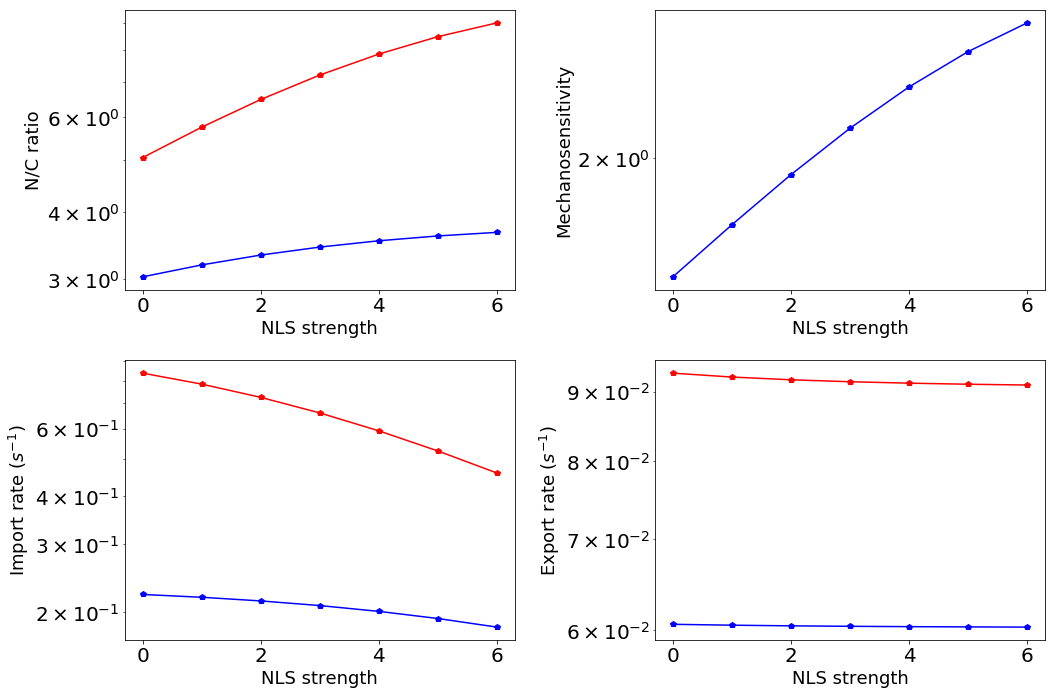

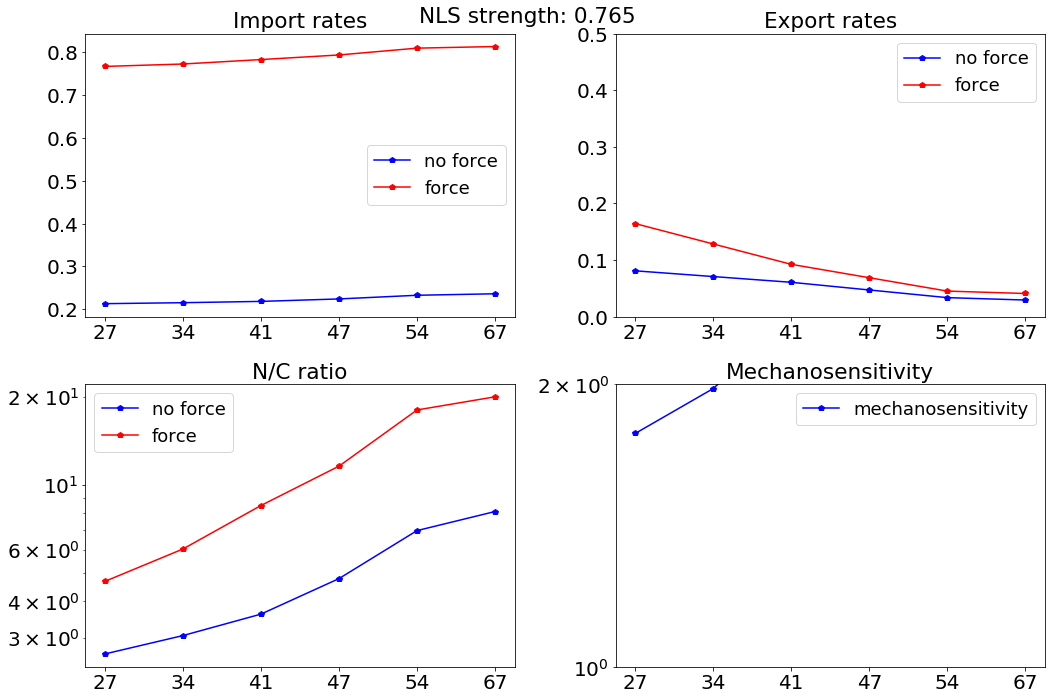

In [60]:
import re
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 18}) 


def make_graph_from_file(filename, NLS, ax=None):
    res = get_res_by_filename(filename)
    plot_mechanosensitivity('N:C', NLS, res, ax=ax)
    xvals = get_xvals_from_filename(filename)
    ax.set_title(f"x_start: {xvals[0]} x_end: {xvals[1]}, NLS strength: {get_free_to_complex_rate(NLS) :.2f}")
    
    
def make_graph(x_start, x_end, ran_factor, NLS, ax=None):
    res = get_res_by_x(x_start, x_end, ran_factor)
    plot_mechanosensitivity('N:C', NLS, res, ax=ax)
    
def make_graphs_for_NLS(x_start, x_end, NLS, ran_factor=2, axes=None, csv_rows=False):
    """
    Corresponding to A, B, 3G and 3I
    """
    res = get_res_by_x(x_start, x_end, ran_factor)
    if axes is None:
        fig, axes = plt.subplots(2,2, figsize=(15,10))
    
    ax = axes[0] # import-export rates
    plot_by_tag('import', NLS, res, ax[0], "Import rates")
    plot_by_tag('export', NLS, res, ax[1], "Export rates")
    
    ax = axes[1] # N/C - mechanosensitivity
    plot_by_tag('N:C', NLS, res, ax[0], "N/C ratio")
    plot_mechanosensitivity('N:C', NLS, res, ax=ax[1])
    ax[1].set_title("Mechanosensitivity")
    fig.suptitle(f"NLS strength: {get_free_to_complex_rate(NLS):.3f}")
    plt.tight_layout()
    
    #### get rows for csv ####
    if csv_rows:
        rows = []
        # import export rates
        imp = [res['import'][MW][0][NLS] for MW in MWs]
        force_imp = [res['import'][MW][1][NLS] for MW in MWs]
        rows.append(["Import rates"] + list(MWs))
        rows.append(["1.5 kPa"] + imp)
        rows.append(["30 kPa"] + force_imp)
        exp = [res['export'][MW][0][NLS] for MW in MWs]
        force_exp = [res['export'][MW][1][NLS] for MW in MWs]
        rows.append(["Export rates"] + list(MWs))
        rows.append(["1.5 kPa"] + exp)
        rows.append(["30 kPa"] + force_exp)
        
        # N/C ratios
        n2c = [res['N:C'][MW][0][NLS] for MW in MWs]
        force_n2c = [res['N:C'][MW][1][NLS] for MW in MWs]
        rows.append(["N/C ratios"] + list(MWs))
        rows.append(["1.5 kPa"] + n2c)
        rows.append(["30 kPa"] + force_n2c)
        
        # mechanosensitivity
        ms = np.array(force_n2c)/np.array(n2c)
        rows.append(["Mechanosensitivity (N/C)"] + list(MWs))
        rows.append([""] + list(ms))
        return rows
        
    
def make_graphs_for_MW(x_start, x_end, MW=41, ran_factor=2, axes=None, csv_rows=False):
    res = get_res_by_x(x_start, x_end, ran_factor)
    if axes is None:
        fig, axes = plt.subplots(2,2, figsize=(15,10))
        
    #### mechanosensitivity by NLS strength ####
    ax = axes[0] 
    
    n2c_no_force = np.array([res["N:C"][MW][0][NLS] for NLS in range(n_NLS)])
    n2c_force = np.array([res["N:C"][MW][1][NLS] for NLS in range(n_NLS)])
    mechanosensitivity = n2c_force/n2c_no_force
    ax[0].plot(np.arange(n_NLS), n2c_no_force, 'bp-', label="1.5 kPa")
    ax[0].plot(np.arange(n_NLS), n2c_force, 'rp-', label="30 kPa")
    ax[0].set_yscale('log')
    ax[0].set_xlabel("NLS strength")
    #ax[0].set_xticklabels([0, "L_NLS", "M_NLS", "H_NLS"])
    ax[0].set_ylabel("N/C ratio")
    
    ax[1].plot(np.arange(n_NLS), mechanosensitivity, 'bp-')
    #ax[1].set_ylim((0.5,2))
    ax[1].set_yscale('log')
    ax[1].set_xlabel("NLS strength")
    #ax[1].set_xticklabels([0, "0", "L_NLS", "M_NLS", "H_NLS"])
    ax[1].set_ylabel("Mechanosensitivity")
    
    #### Leakage effects ####
    ax = axes[1]
    imp_no_force = np.flip(np.array([res["import"][MW][0][NLS] for NLS in range(n_NLS)]))
    imp_force = np.flip(np.array([res["import"][MW][1][NLS] for NLS in range(n_NLS)]))
    ax[0].plot(imp_no_force, 'bp-', label="1.5 kPa")
    ax[0].plot(imp_force, 'rp-', label="30 kPa")
    ax[0].set_yscale('log')
    ax[0].set_xlabel("NLS strength")
    #ax[0].set_xticklabels([0, "H_NLS", "M_NLS", "L_NLS", "0"])
    ax[0].set_ylabel(r"Import rate $(s^{-1})$")
    
    exp_no_force = np.flip(np.array([res["export"][MW][0][NLS] for NLS in range(n_NLS)]))
    exp_force = np.flip(np.array([res["export"][MW][1][NLS] for NLS in range(n_NLS)]))
    ax[1].plot(exp_no_force, 'bp-', label="1.5 kPa")
    ax[1].plot(exp_force, 'rp-', label="30 kPa")
    ax[1].set_yscale('log')
    ax[1].set_xlabel("NLS strength")
    #ax[1].set_xticklabels([0, "H_NLS", "M_NLS", "L_NLS", "0"])
    ax[1].set_ylabel(r"Export rate $(s^{-1})$")
    
    fig.tight_layout()
    
    #### get rows for csv ####
    if csv_rows:
        rows = []
        # NLS to N/C:
        rows.append(["NLS strength and N/C ratios"] + list(free_to_complex_rates))
        rows.append(["1.5 kPa"] + list(n2c_no_force))
        rows.append(["30 kPa"] + list(n2c_force))
        # Mechanosensitivity
        rows.append(["Mechanosensitivity"] + list(free_to_complex_rates))
        rows.append([""] + list(mechanosensitivity))
        # Leakage
        rows.append(["Leakage"] + list(np.flip(free_to_complex_rates)))
        rows.append(["import"]) 
        rows.append(["1.5 kPa"] + list(imp_no_force))
        rows.append(["30 kPa"] + list(imp_force))
        rows.append(["export"]) 
        rows.append(["1.5 kPa"] + list(exp_no_force))
        rows.append(["30 kPa"] + list(exp_force))
        return rows
                    
                    
        
    
def make_full_graphs(x_start, x_end, NLS, ran_factor=1, MW=41, return_csv_rows=False):
    MW_rows = make_graphs_for_MW(x_start, x_end, MW, ran_factor, csv_rows=return_csv_rows)
    NLS_rows = make_graphs_for_NLS(x_start, x_end, NLS, ran_factor, csv_rows=return_csv_rows)
    if return_csv_rows:
        return NLS_rows + MW_rows 
                    
    
#make_graphs_for_MW(5, 15, 41)
#make_graphs_for_NLS(5, 15,6)
rows = make_full_graphs(15, 60, 5, 8,return_csv_rows=True)

In [381]:
for row in rows:
    print(row)

import csv
with open("values.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

['Import rates', 27, 34, 41, 47, 54, 67]
['1.5 kPa', 0.20575108692107089, 0.206395351010304, 0.20715091317507747, 0.2081903379460255, 0.20898513845256927, 0.2091416314524468]
['30 kPa', 0.815988123649023, 0.8218332885286515, 0.8338639743712835, 0.8468925900725107, 0.865978596829538, 0.8702297717078324]
['Export rates', 27, 34, 41, 47, 54, 67]
['1.5 kPa', 0.08569027494178875, 0.07647406396470229, 0.06752636158814541, 0.056173951201470416, 0.045830868850491126, 0.04285297144667656]
['30 kPa', 0.22880057635235776, 0.20078899885461912, 0.17422128691672945, 0.15762243538750256, 0.14176131866141486, 0.13900103155831353]
['N/C ratios', 27, 34, 41, 47, 54, 67]
['1.5 kPa', 2.4010992635397135, 2.698887797606201, 3.067693789573517, 3.7061540153747, 4.559901260882086, 4.880428289703859]
['30 kPa', 3.566372675525255, 4.0930195041313615, 4.786234731277926, 5.372919077080163, 6.108708673166046, 6.260599377923475]
['Mechanosensitivity (N/C)', 27, 34, 41, 47, 54, 67]
['', 1.4853083042754716, 1.51655786

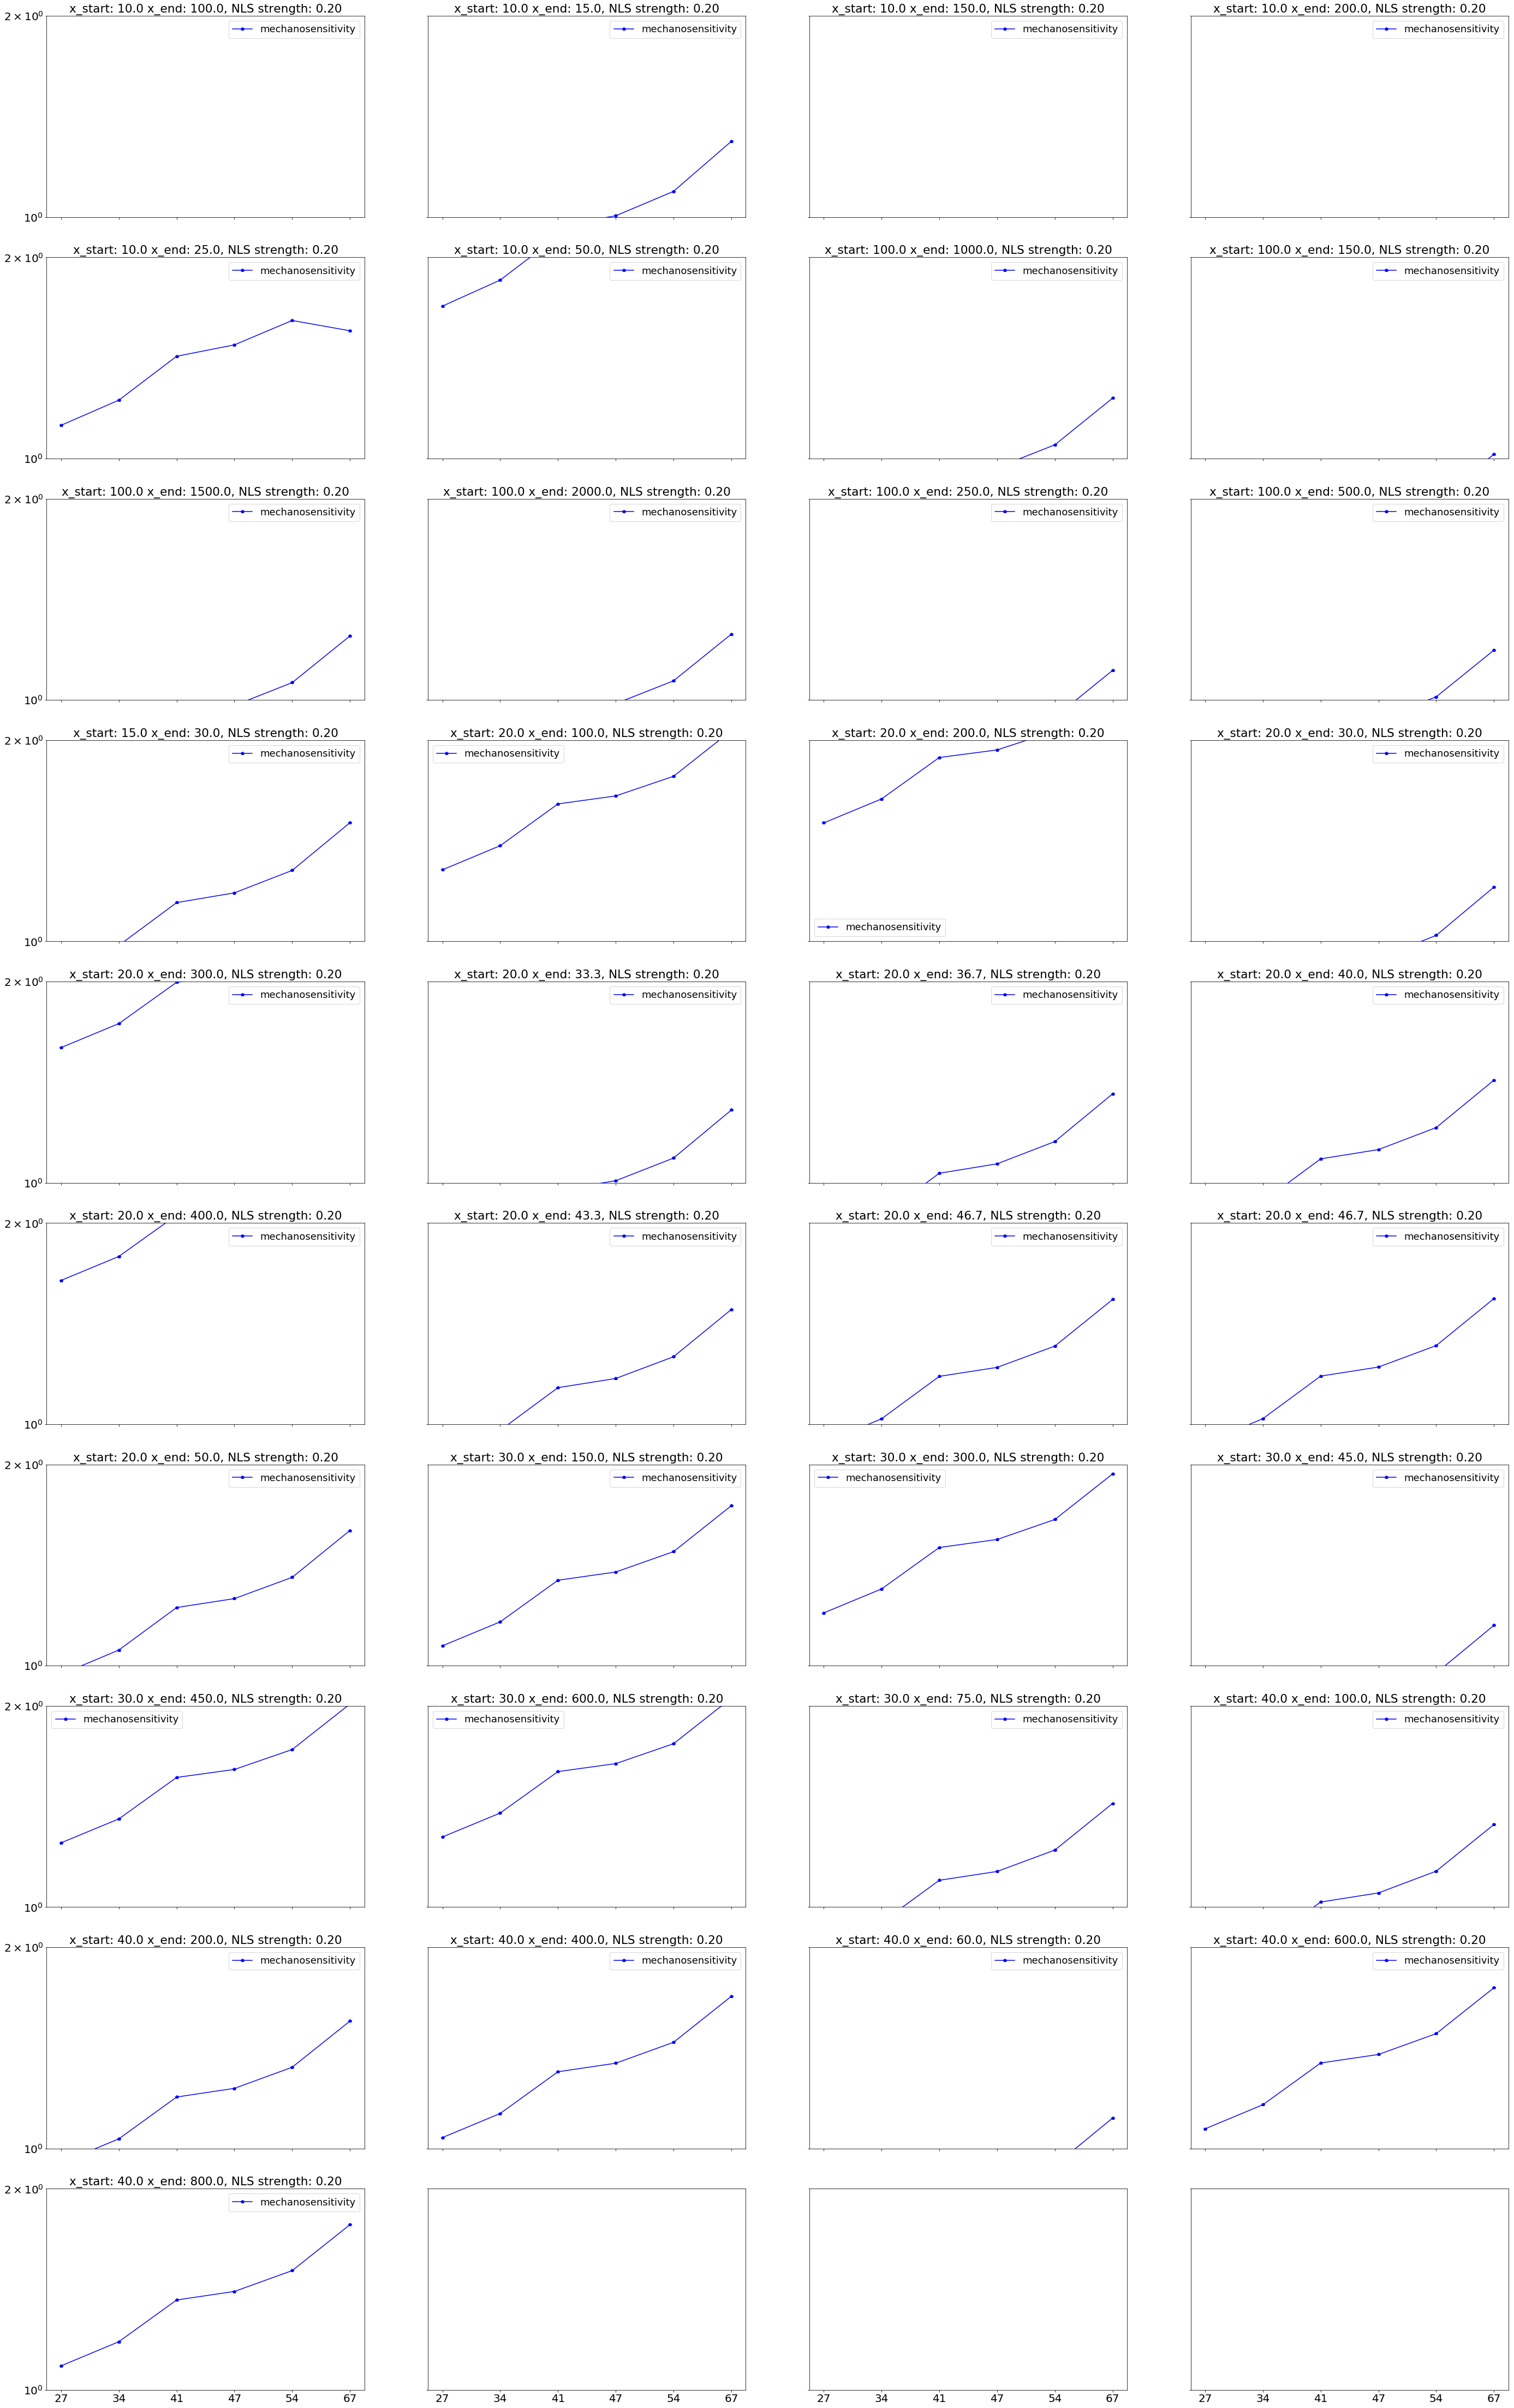

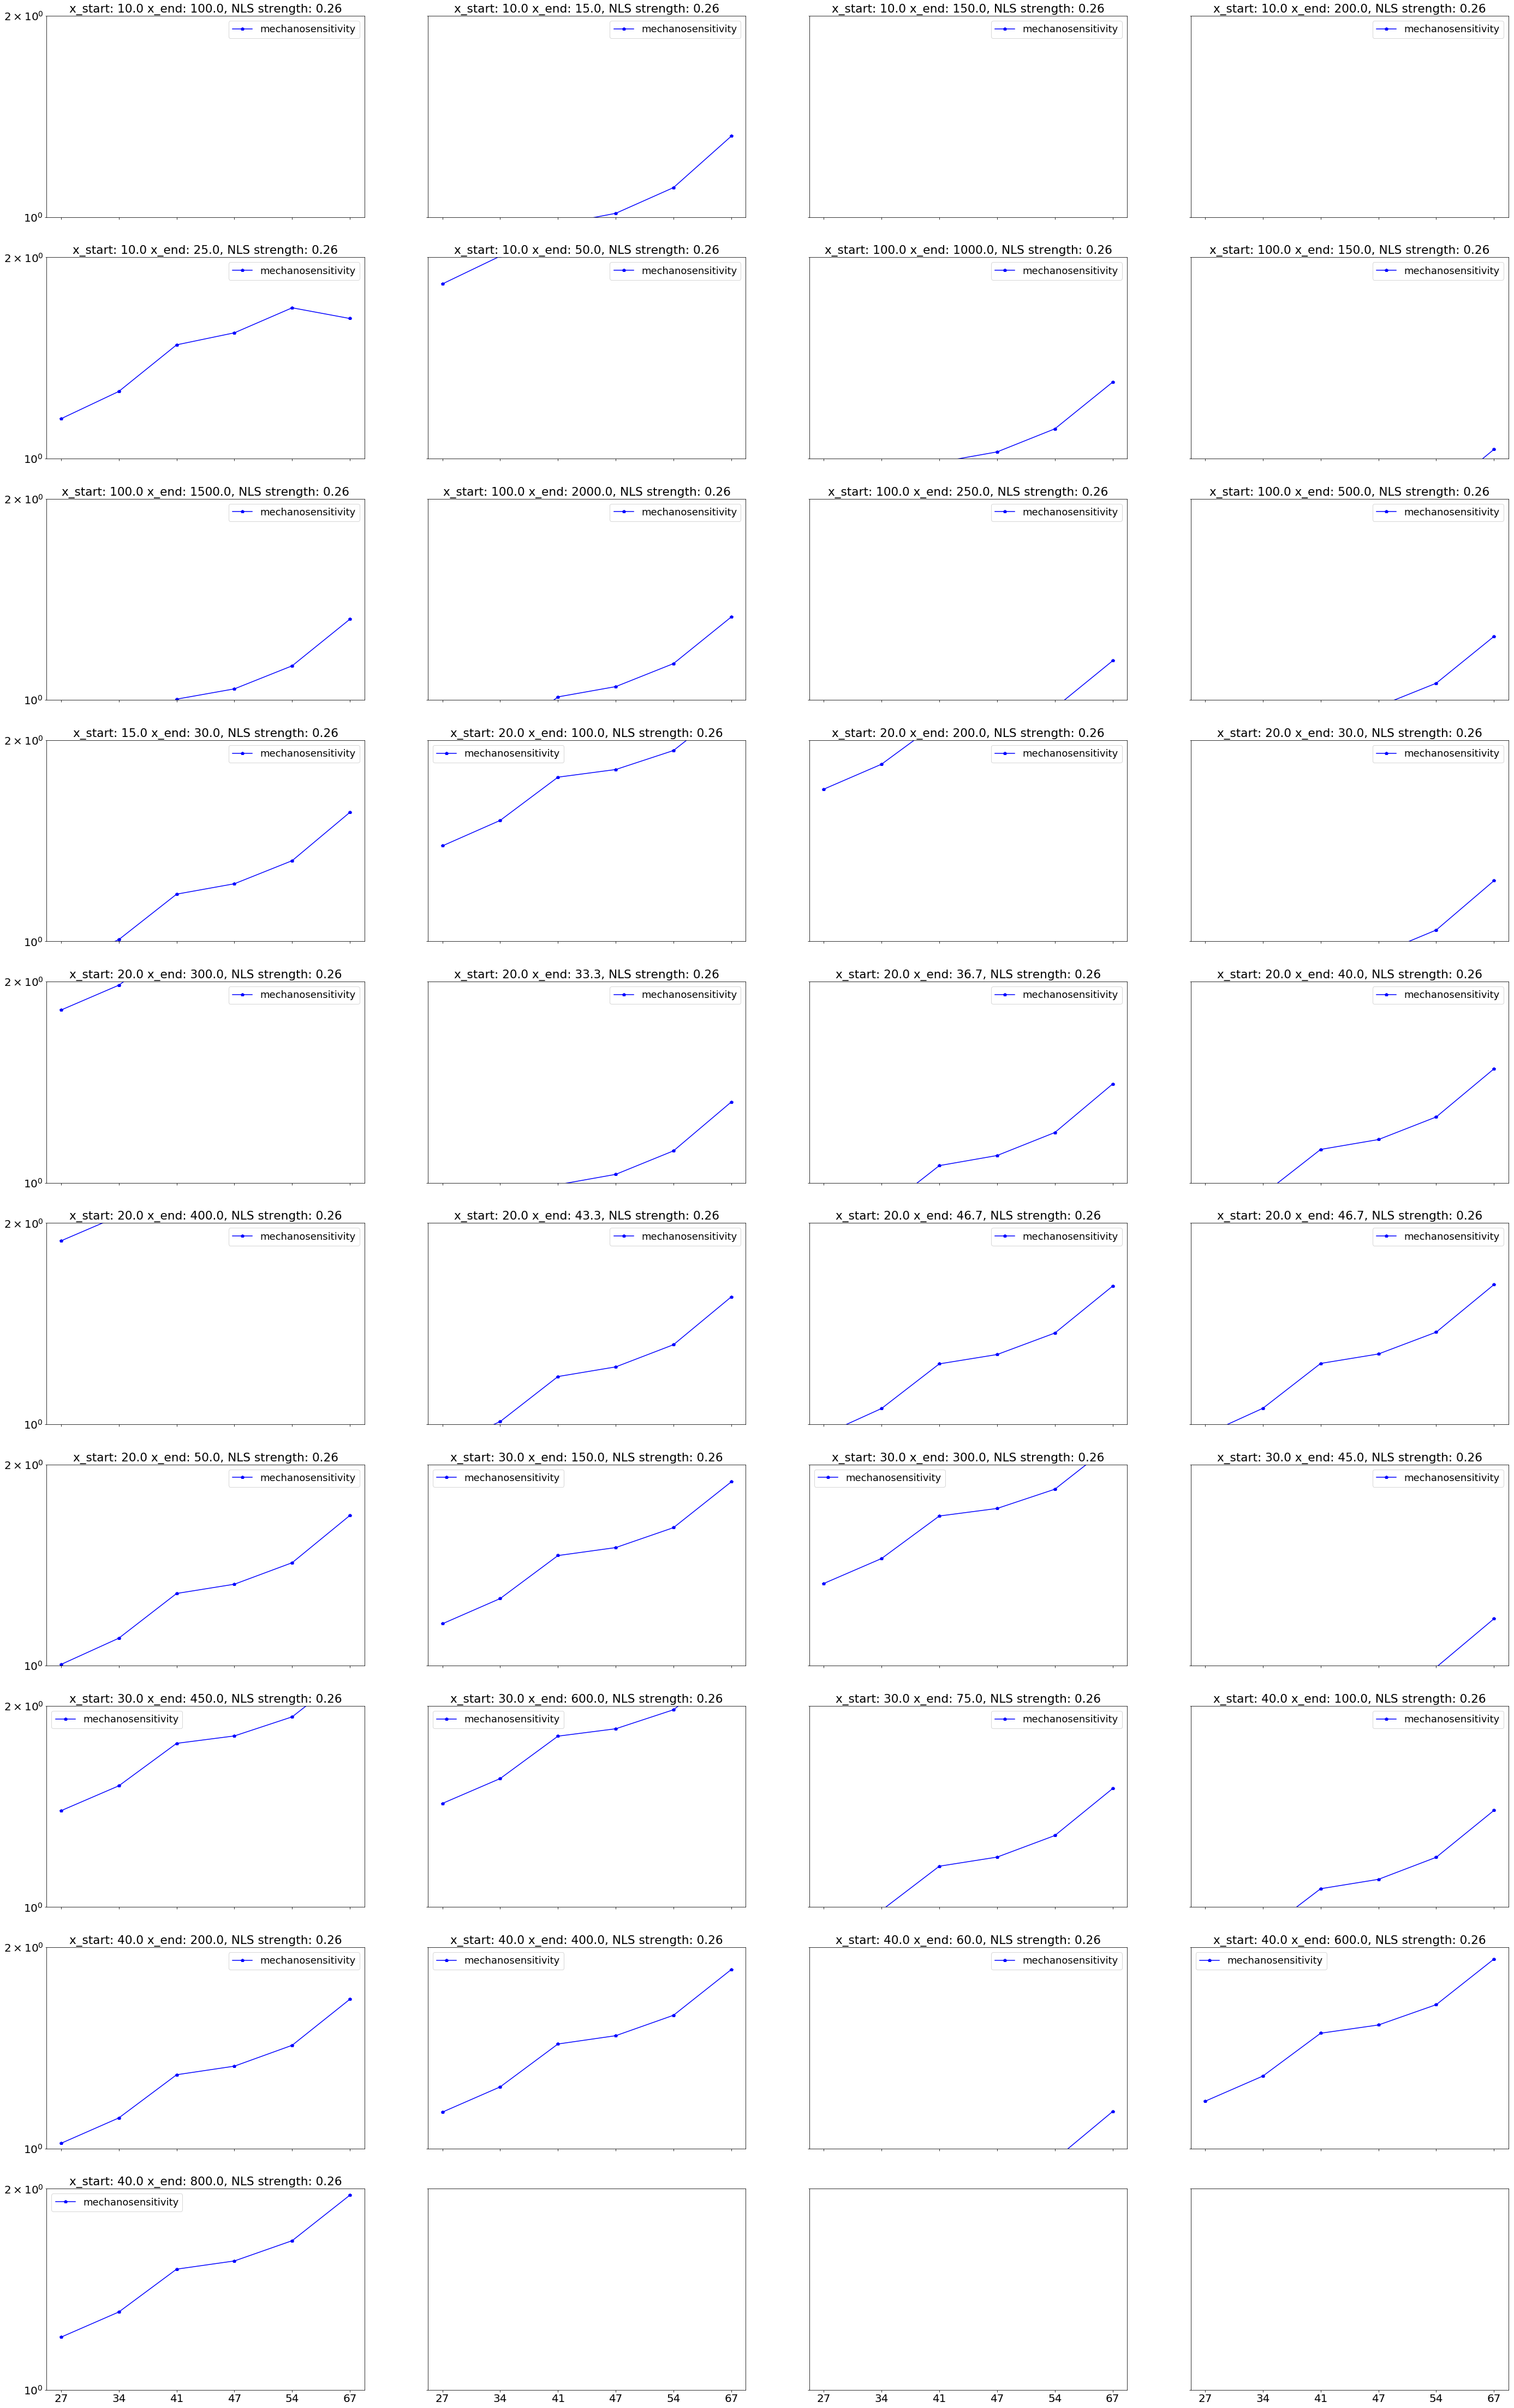

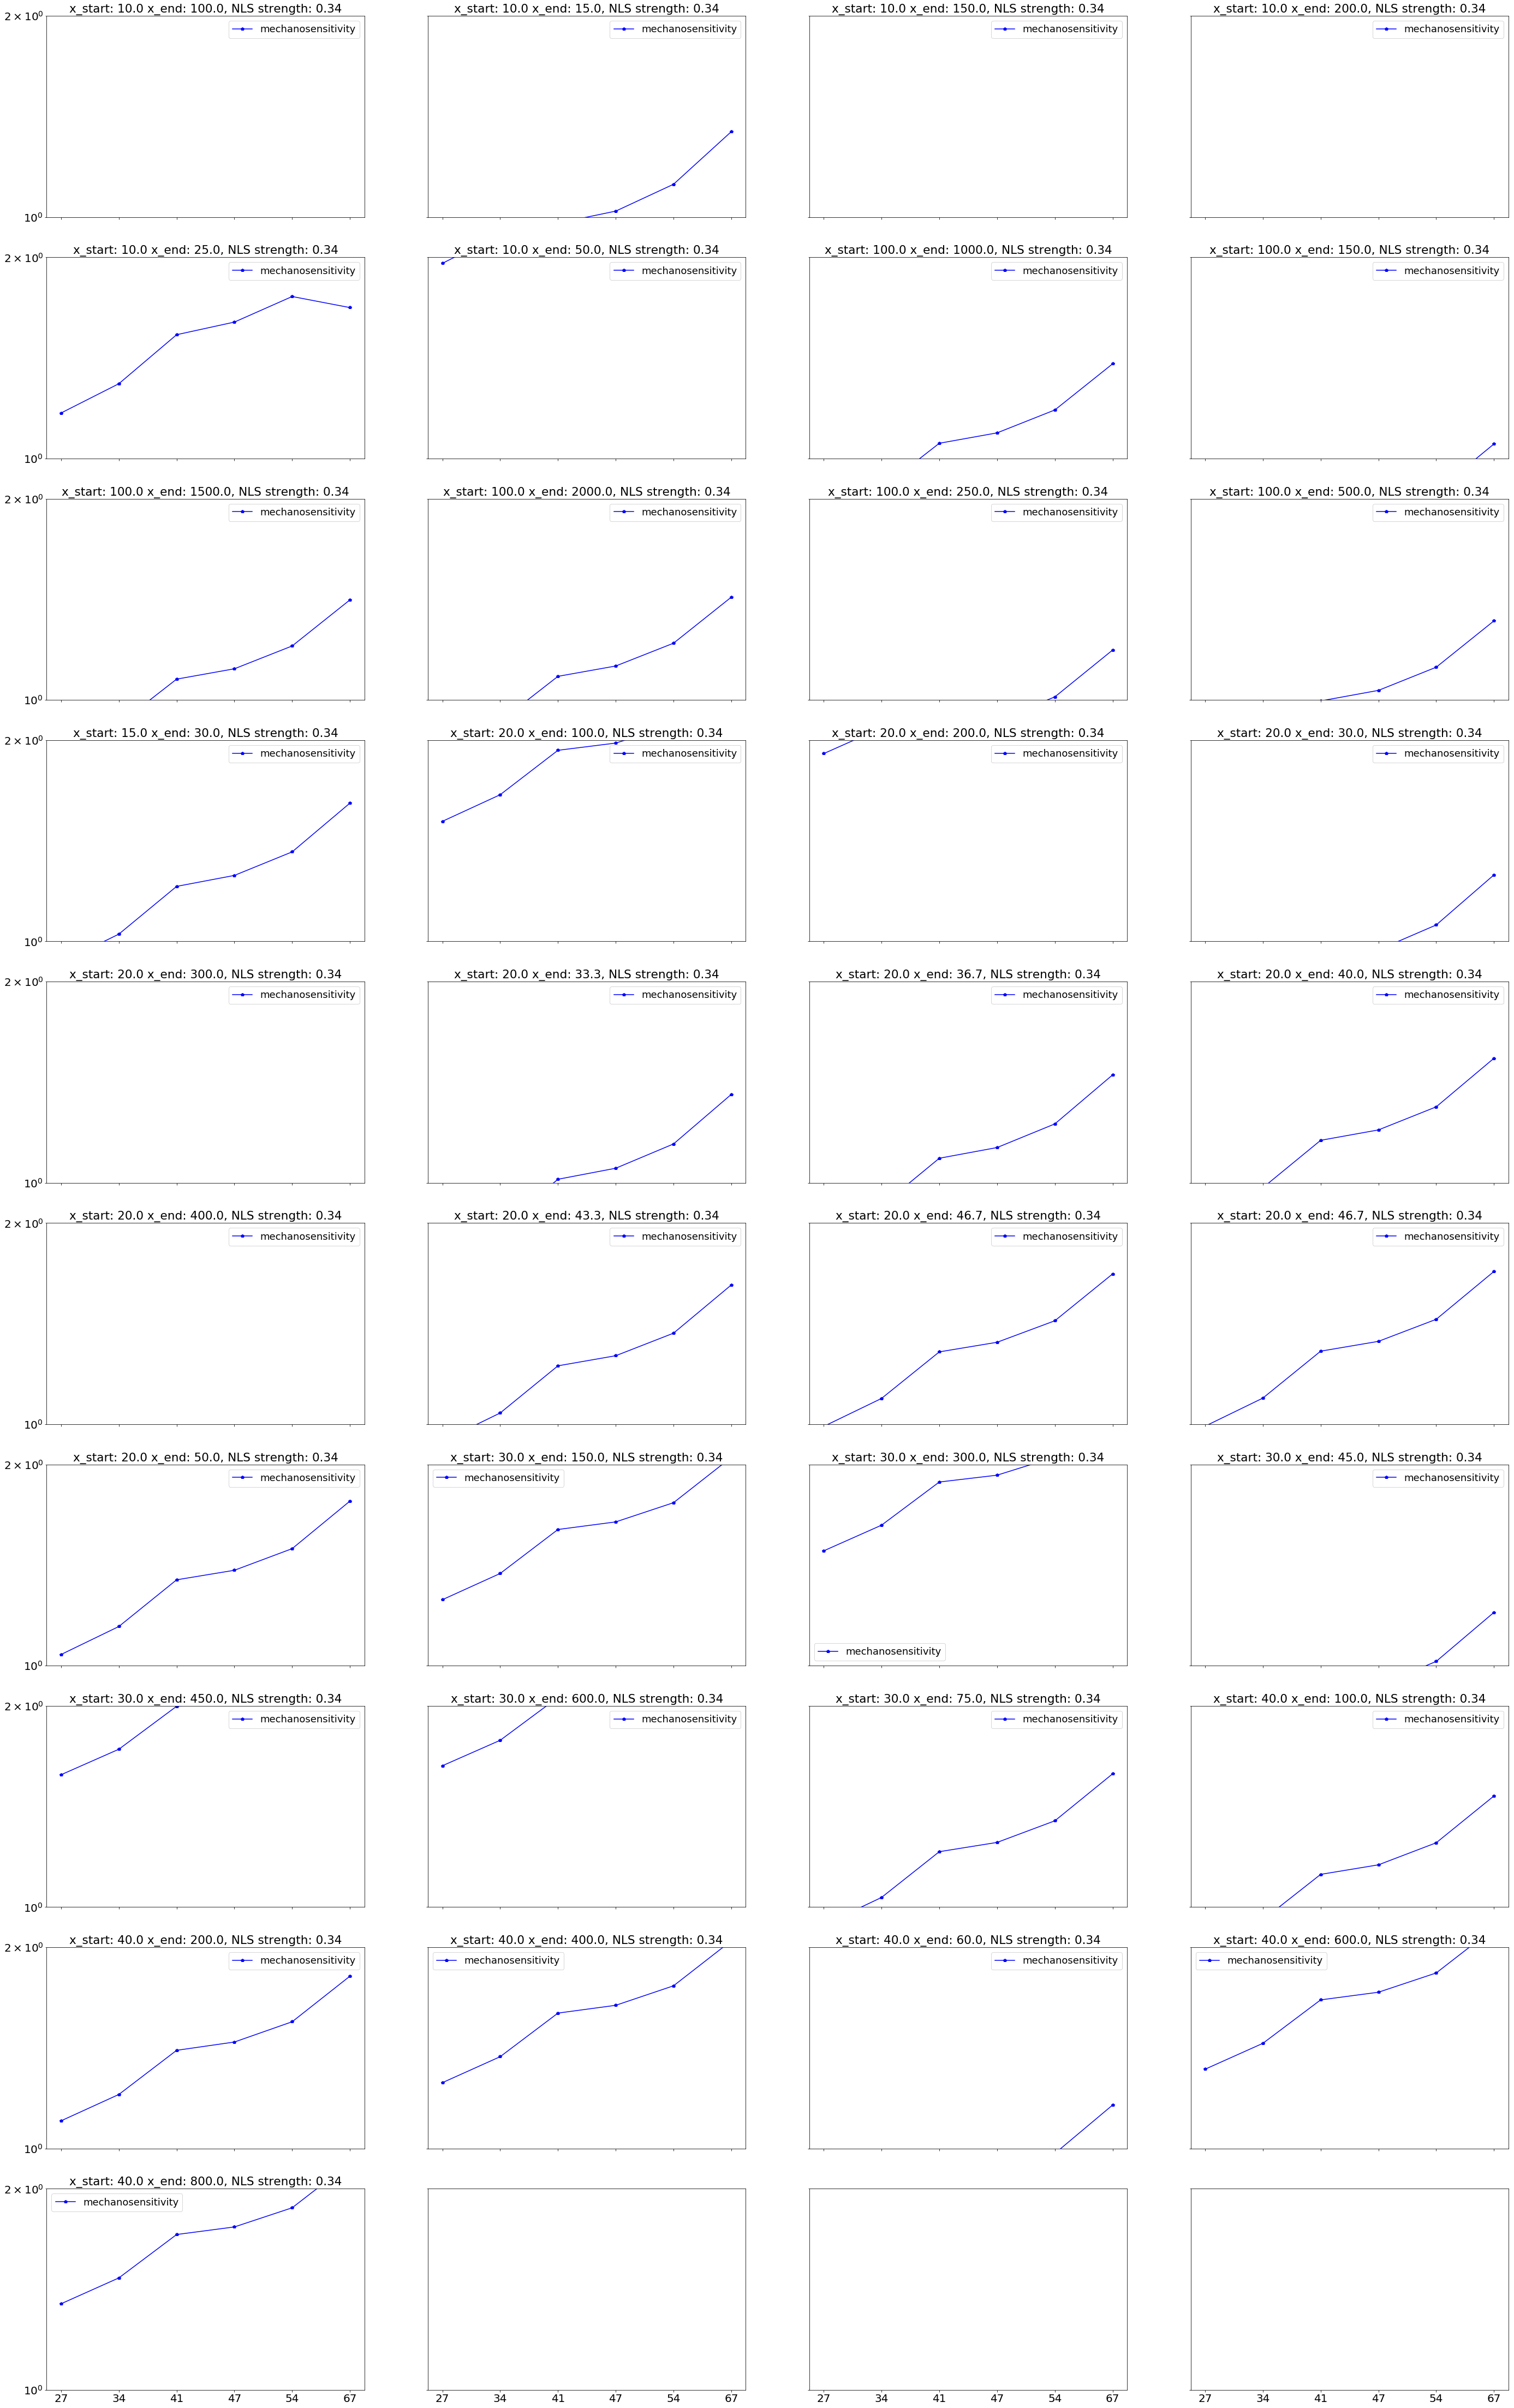

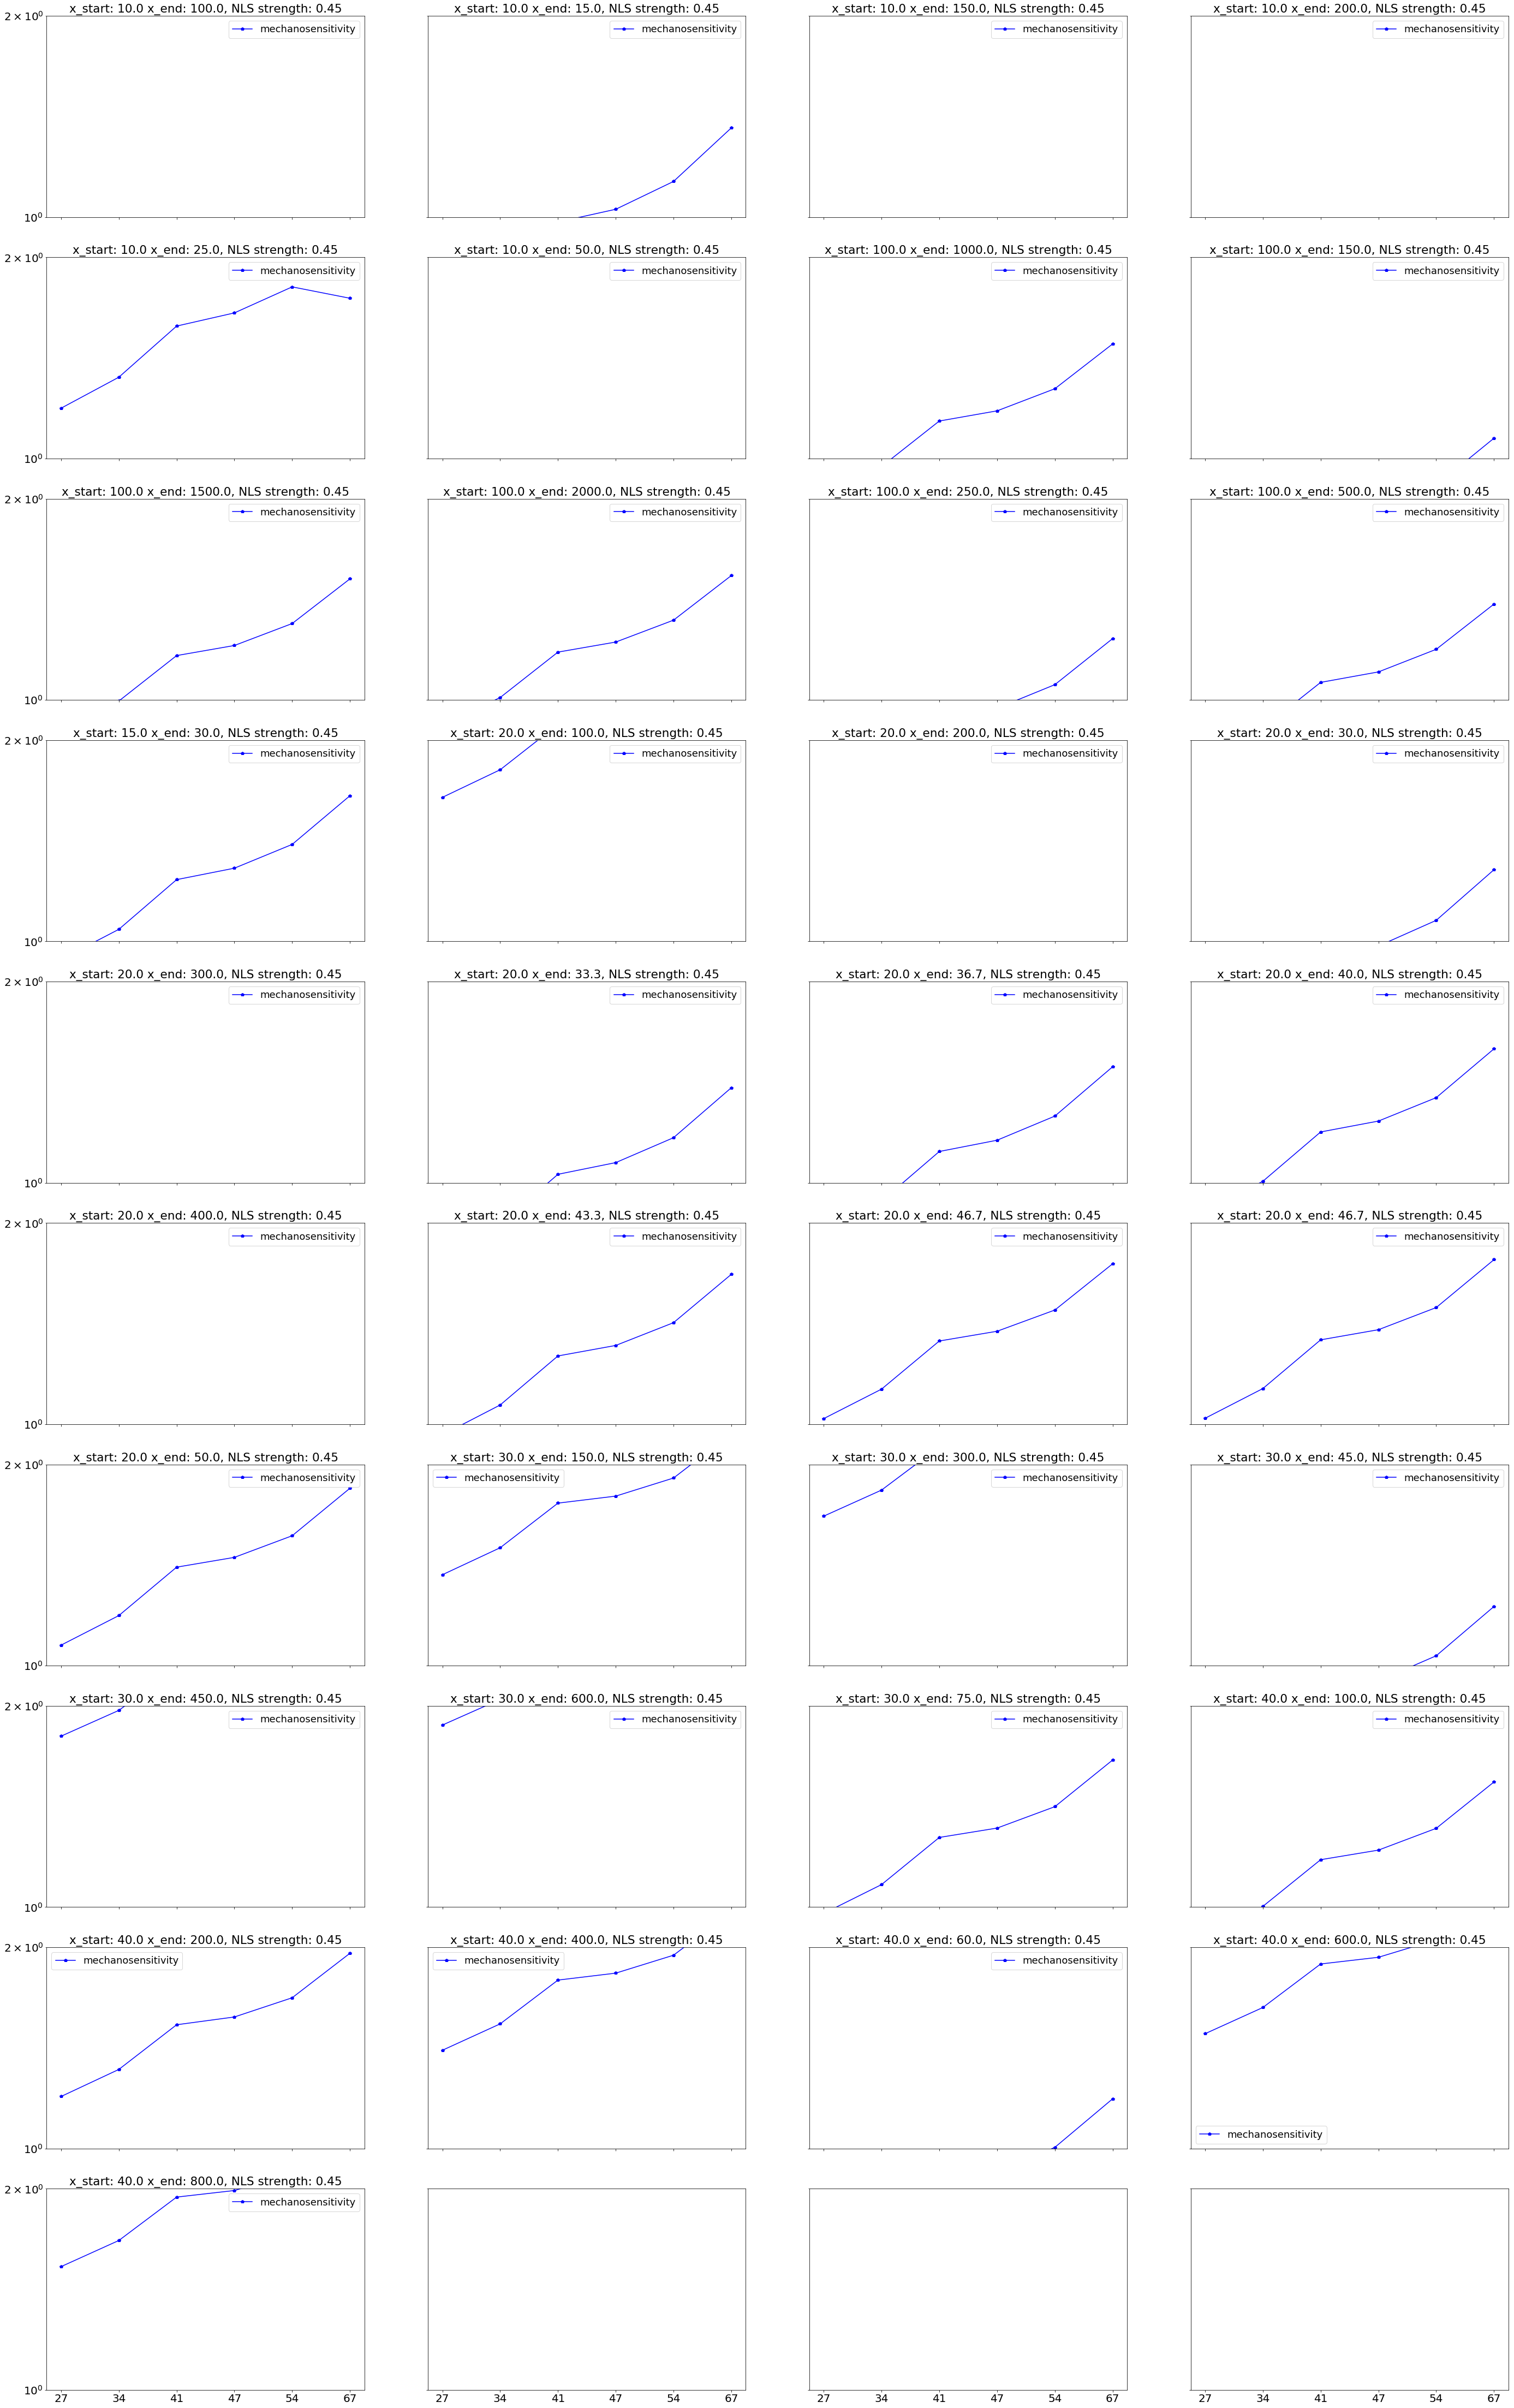

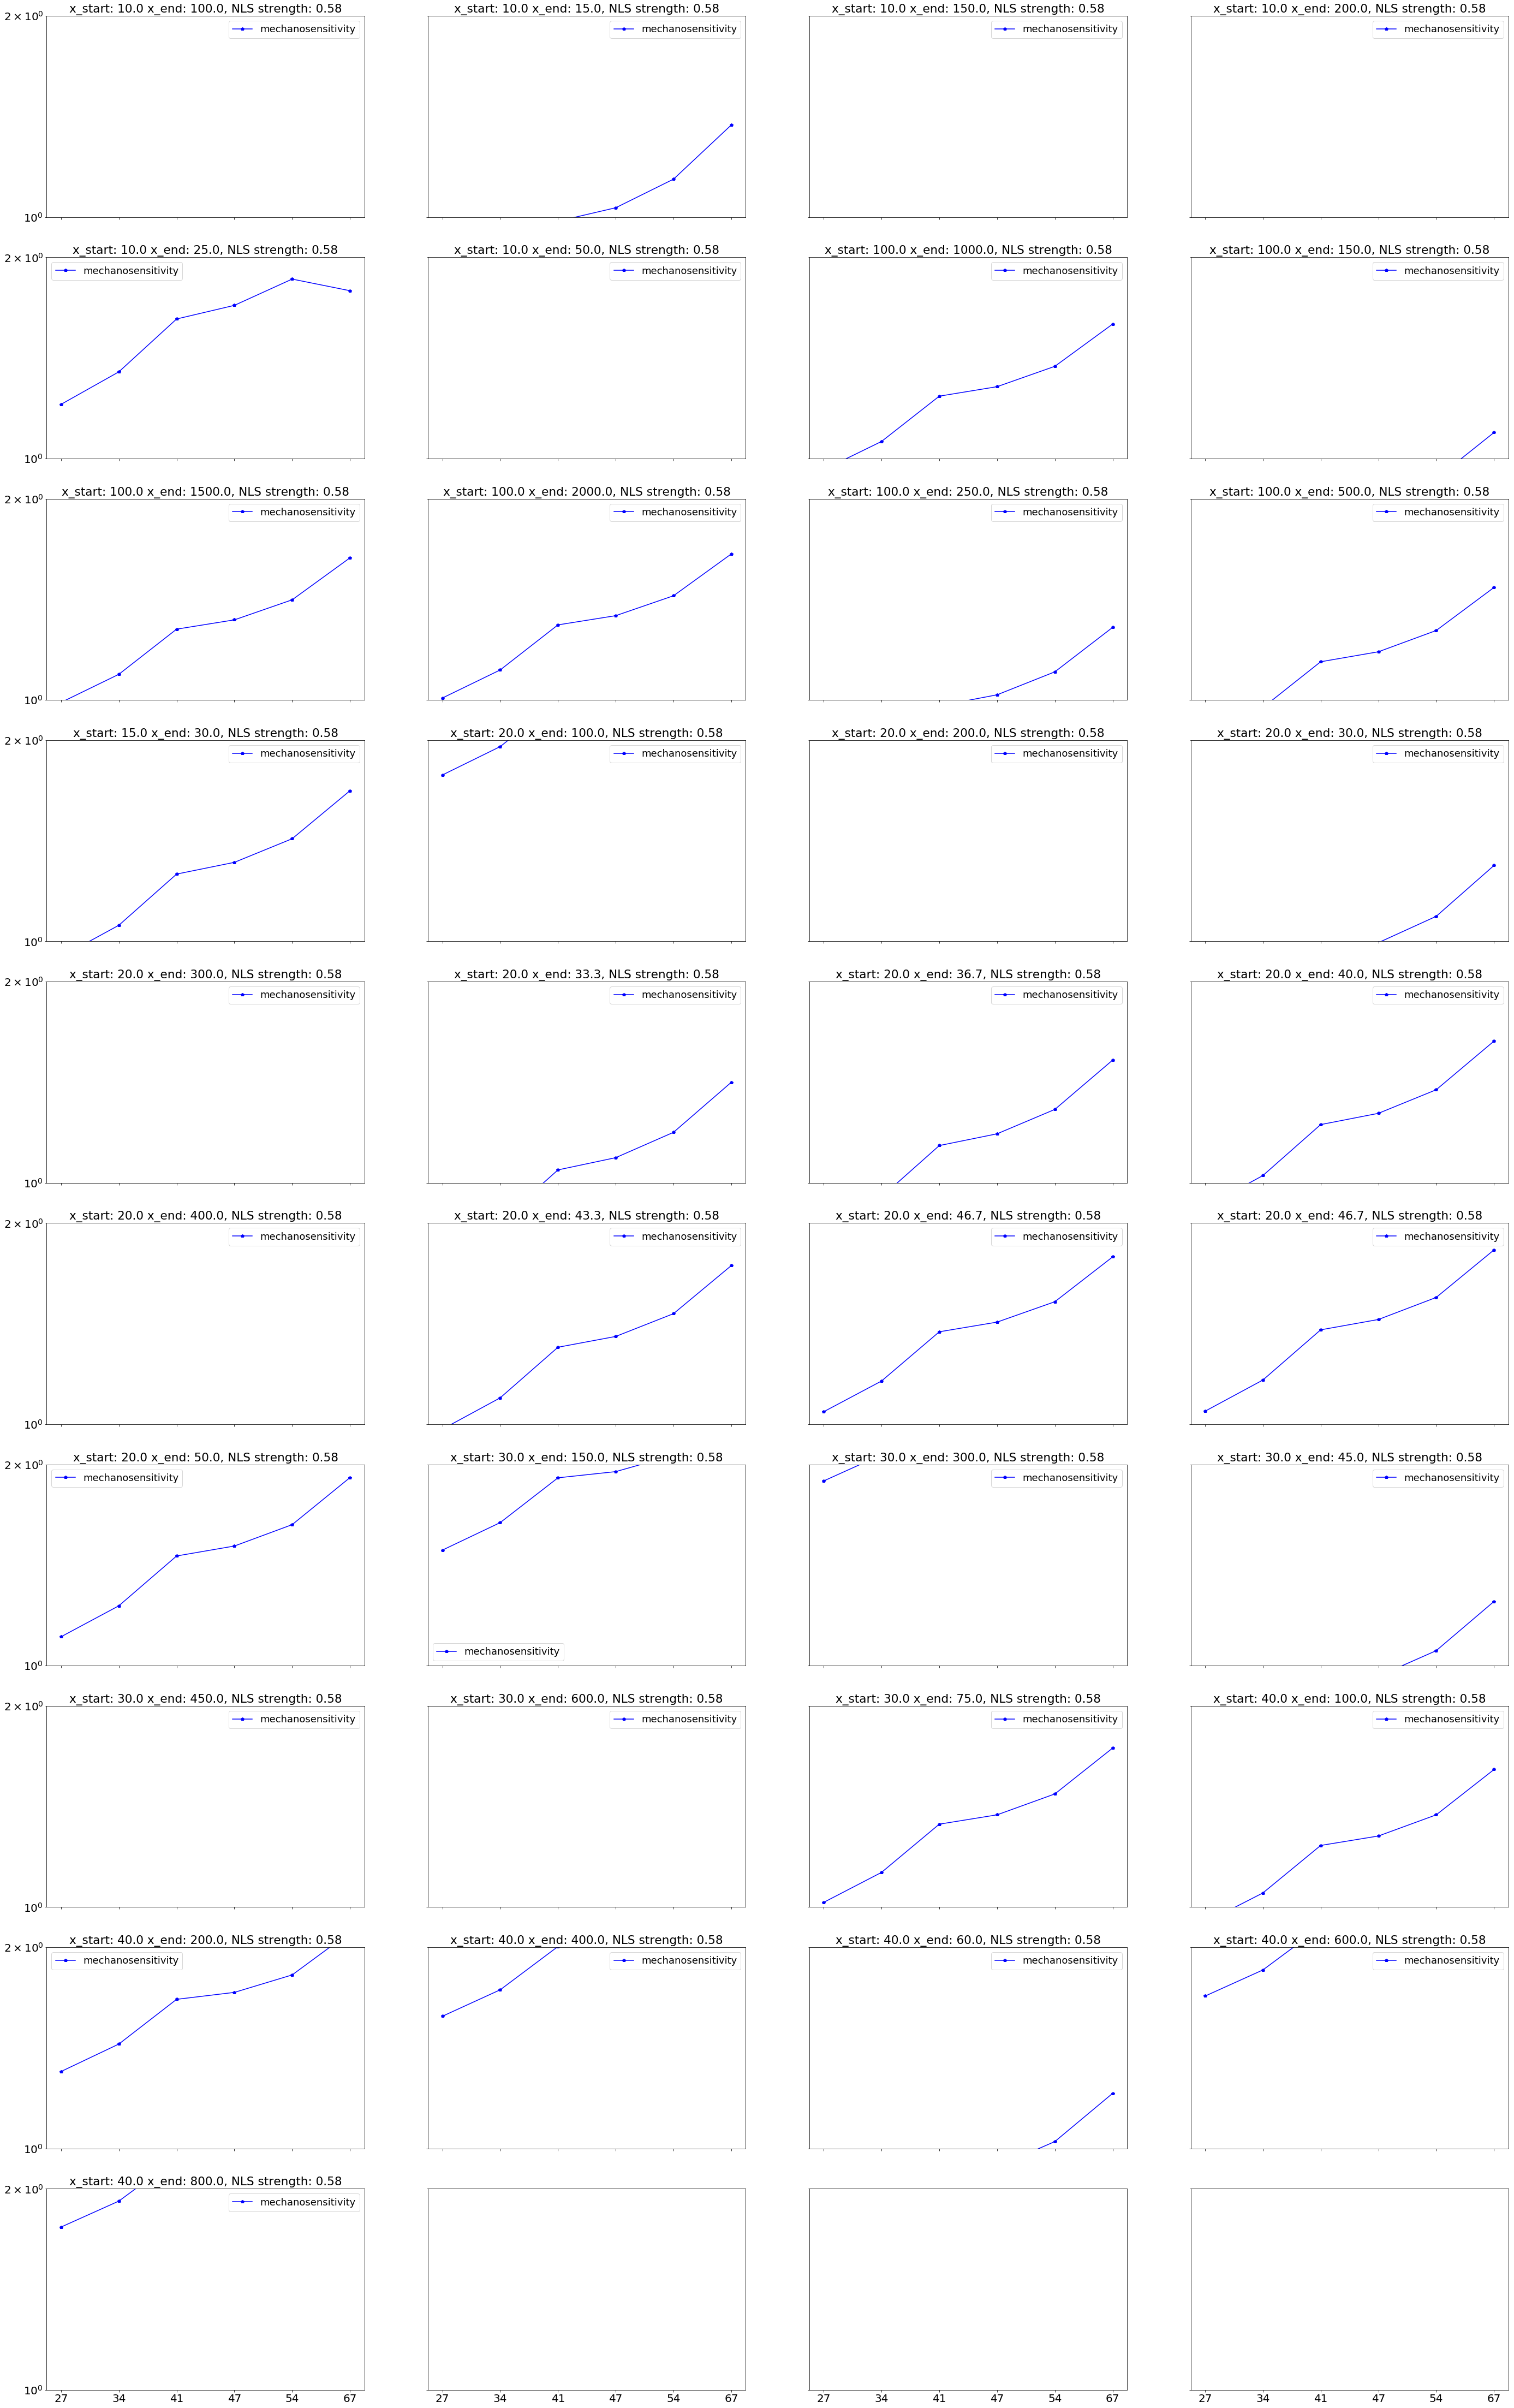

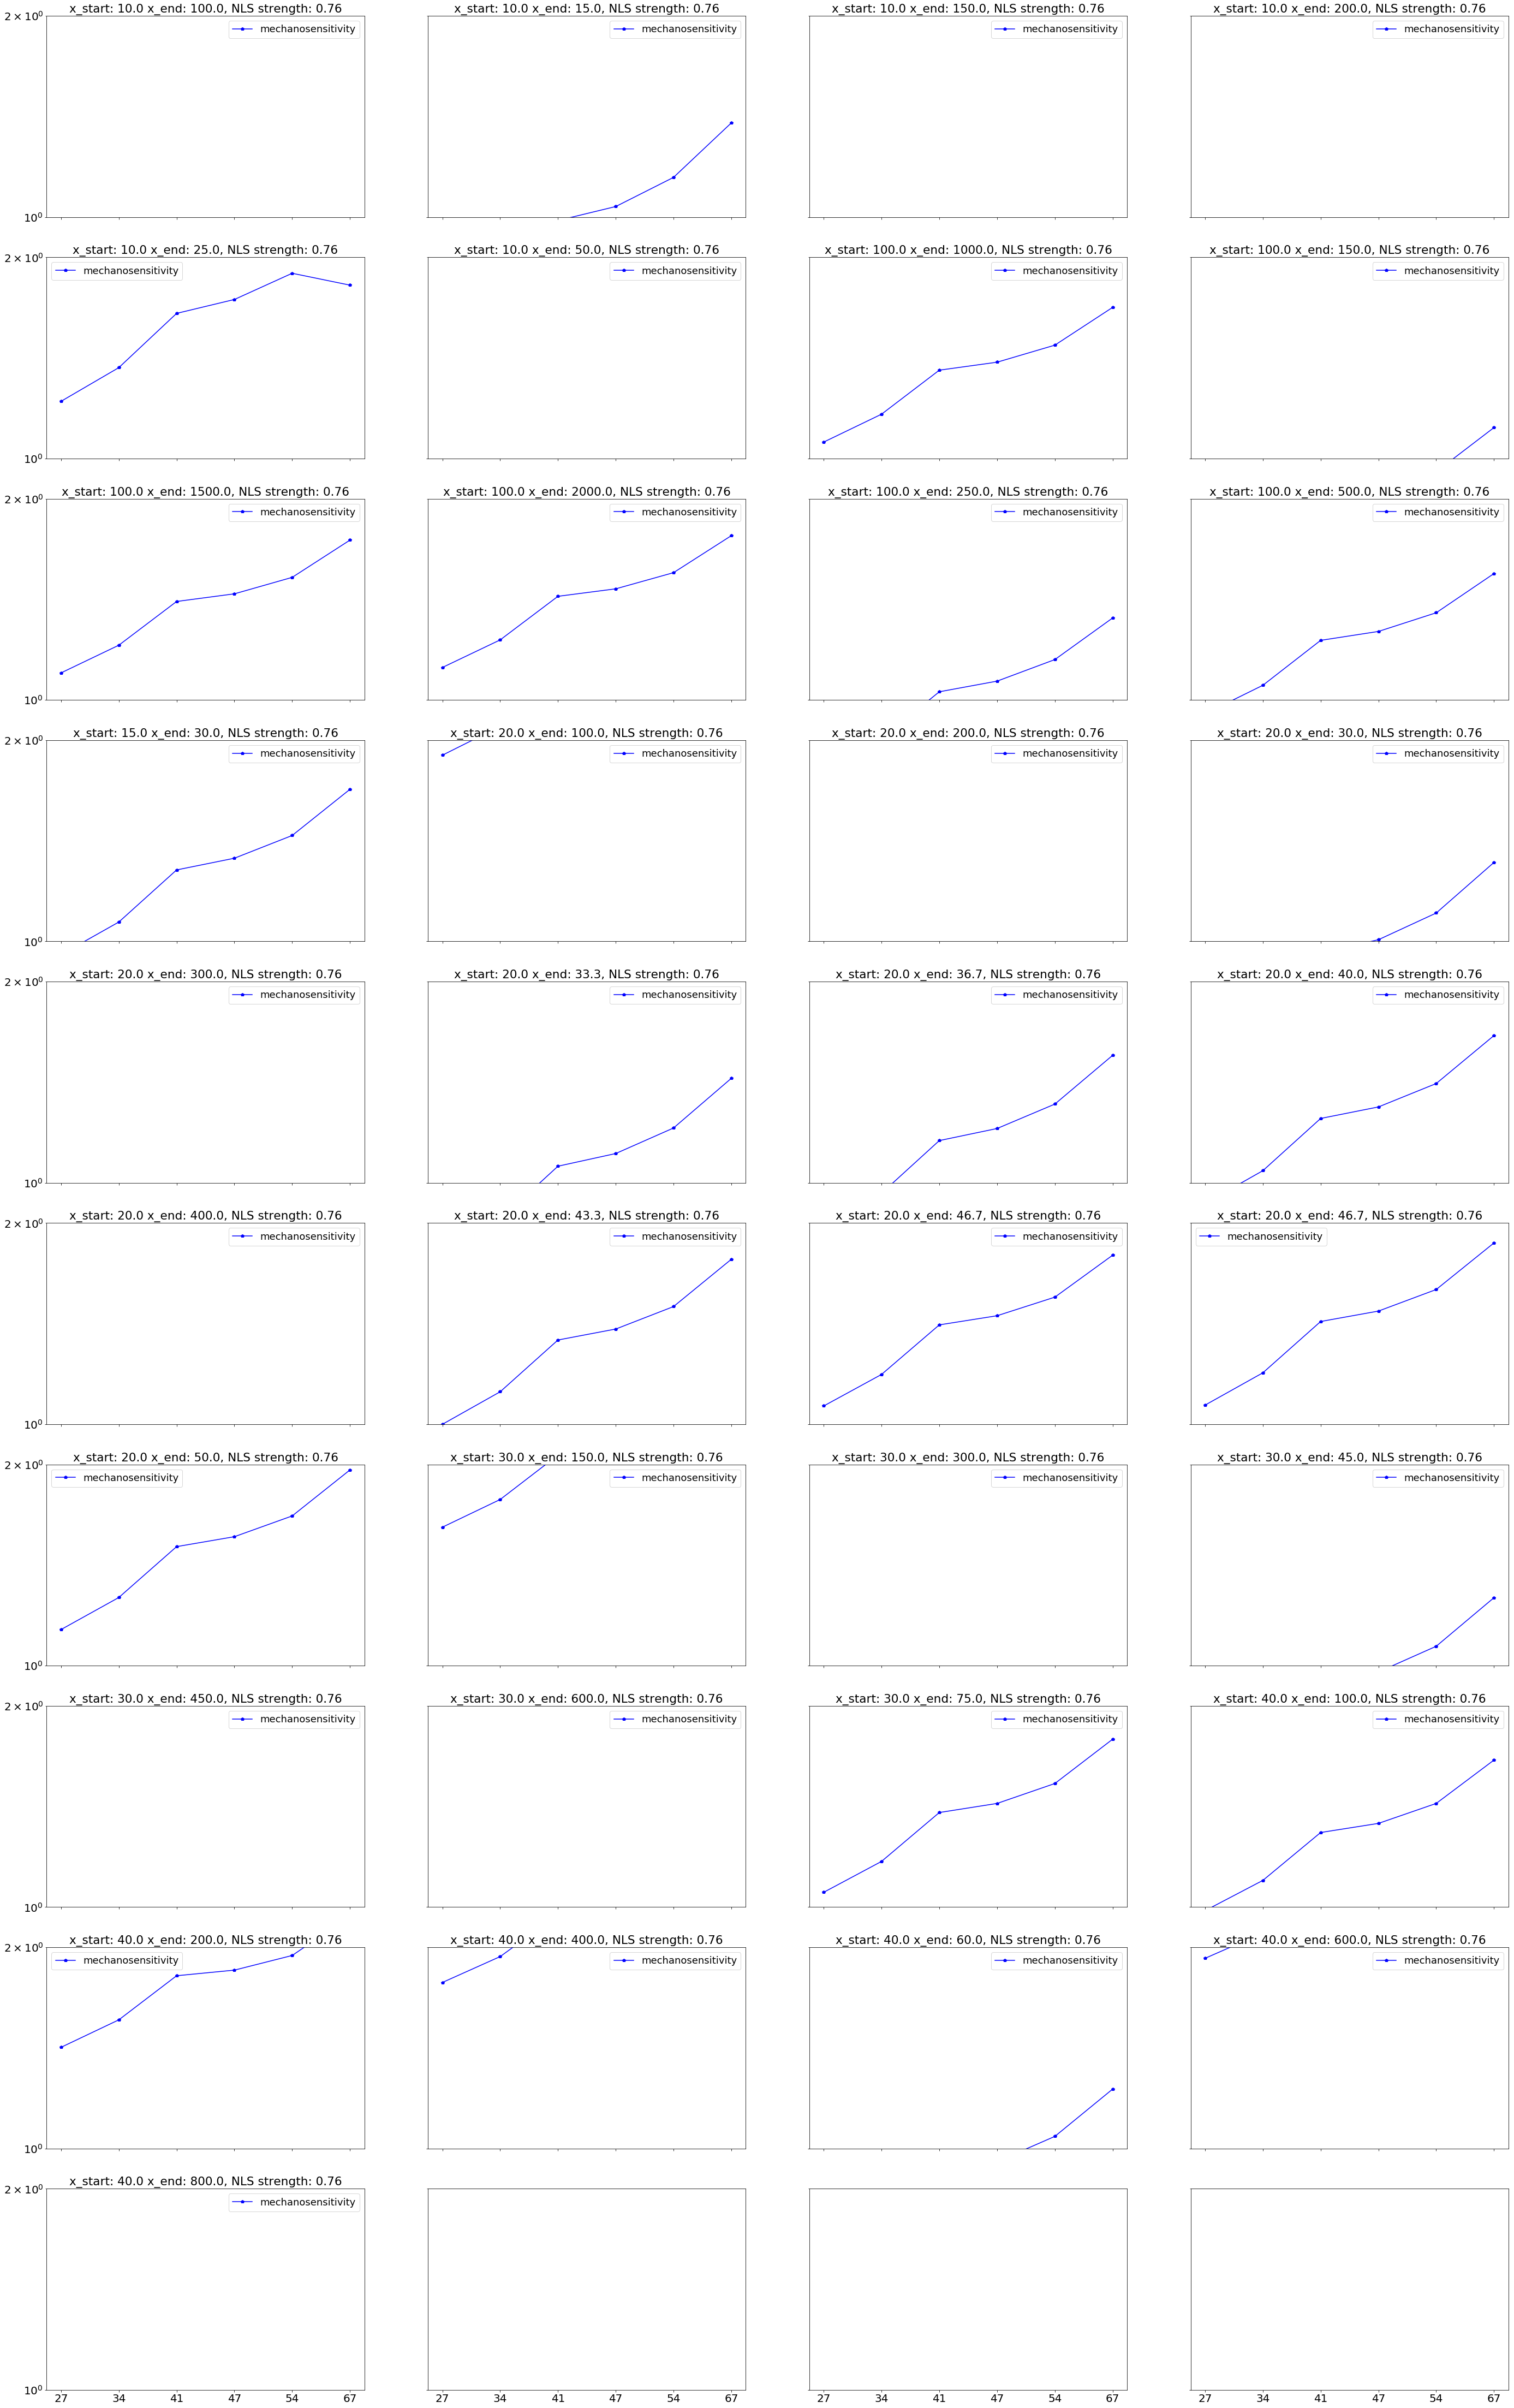

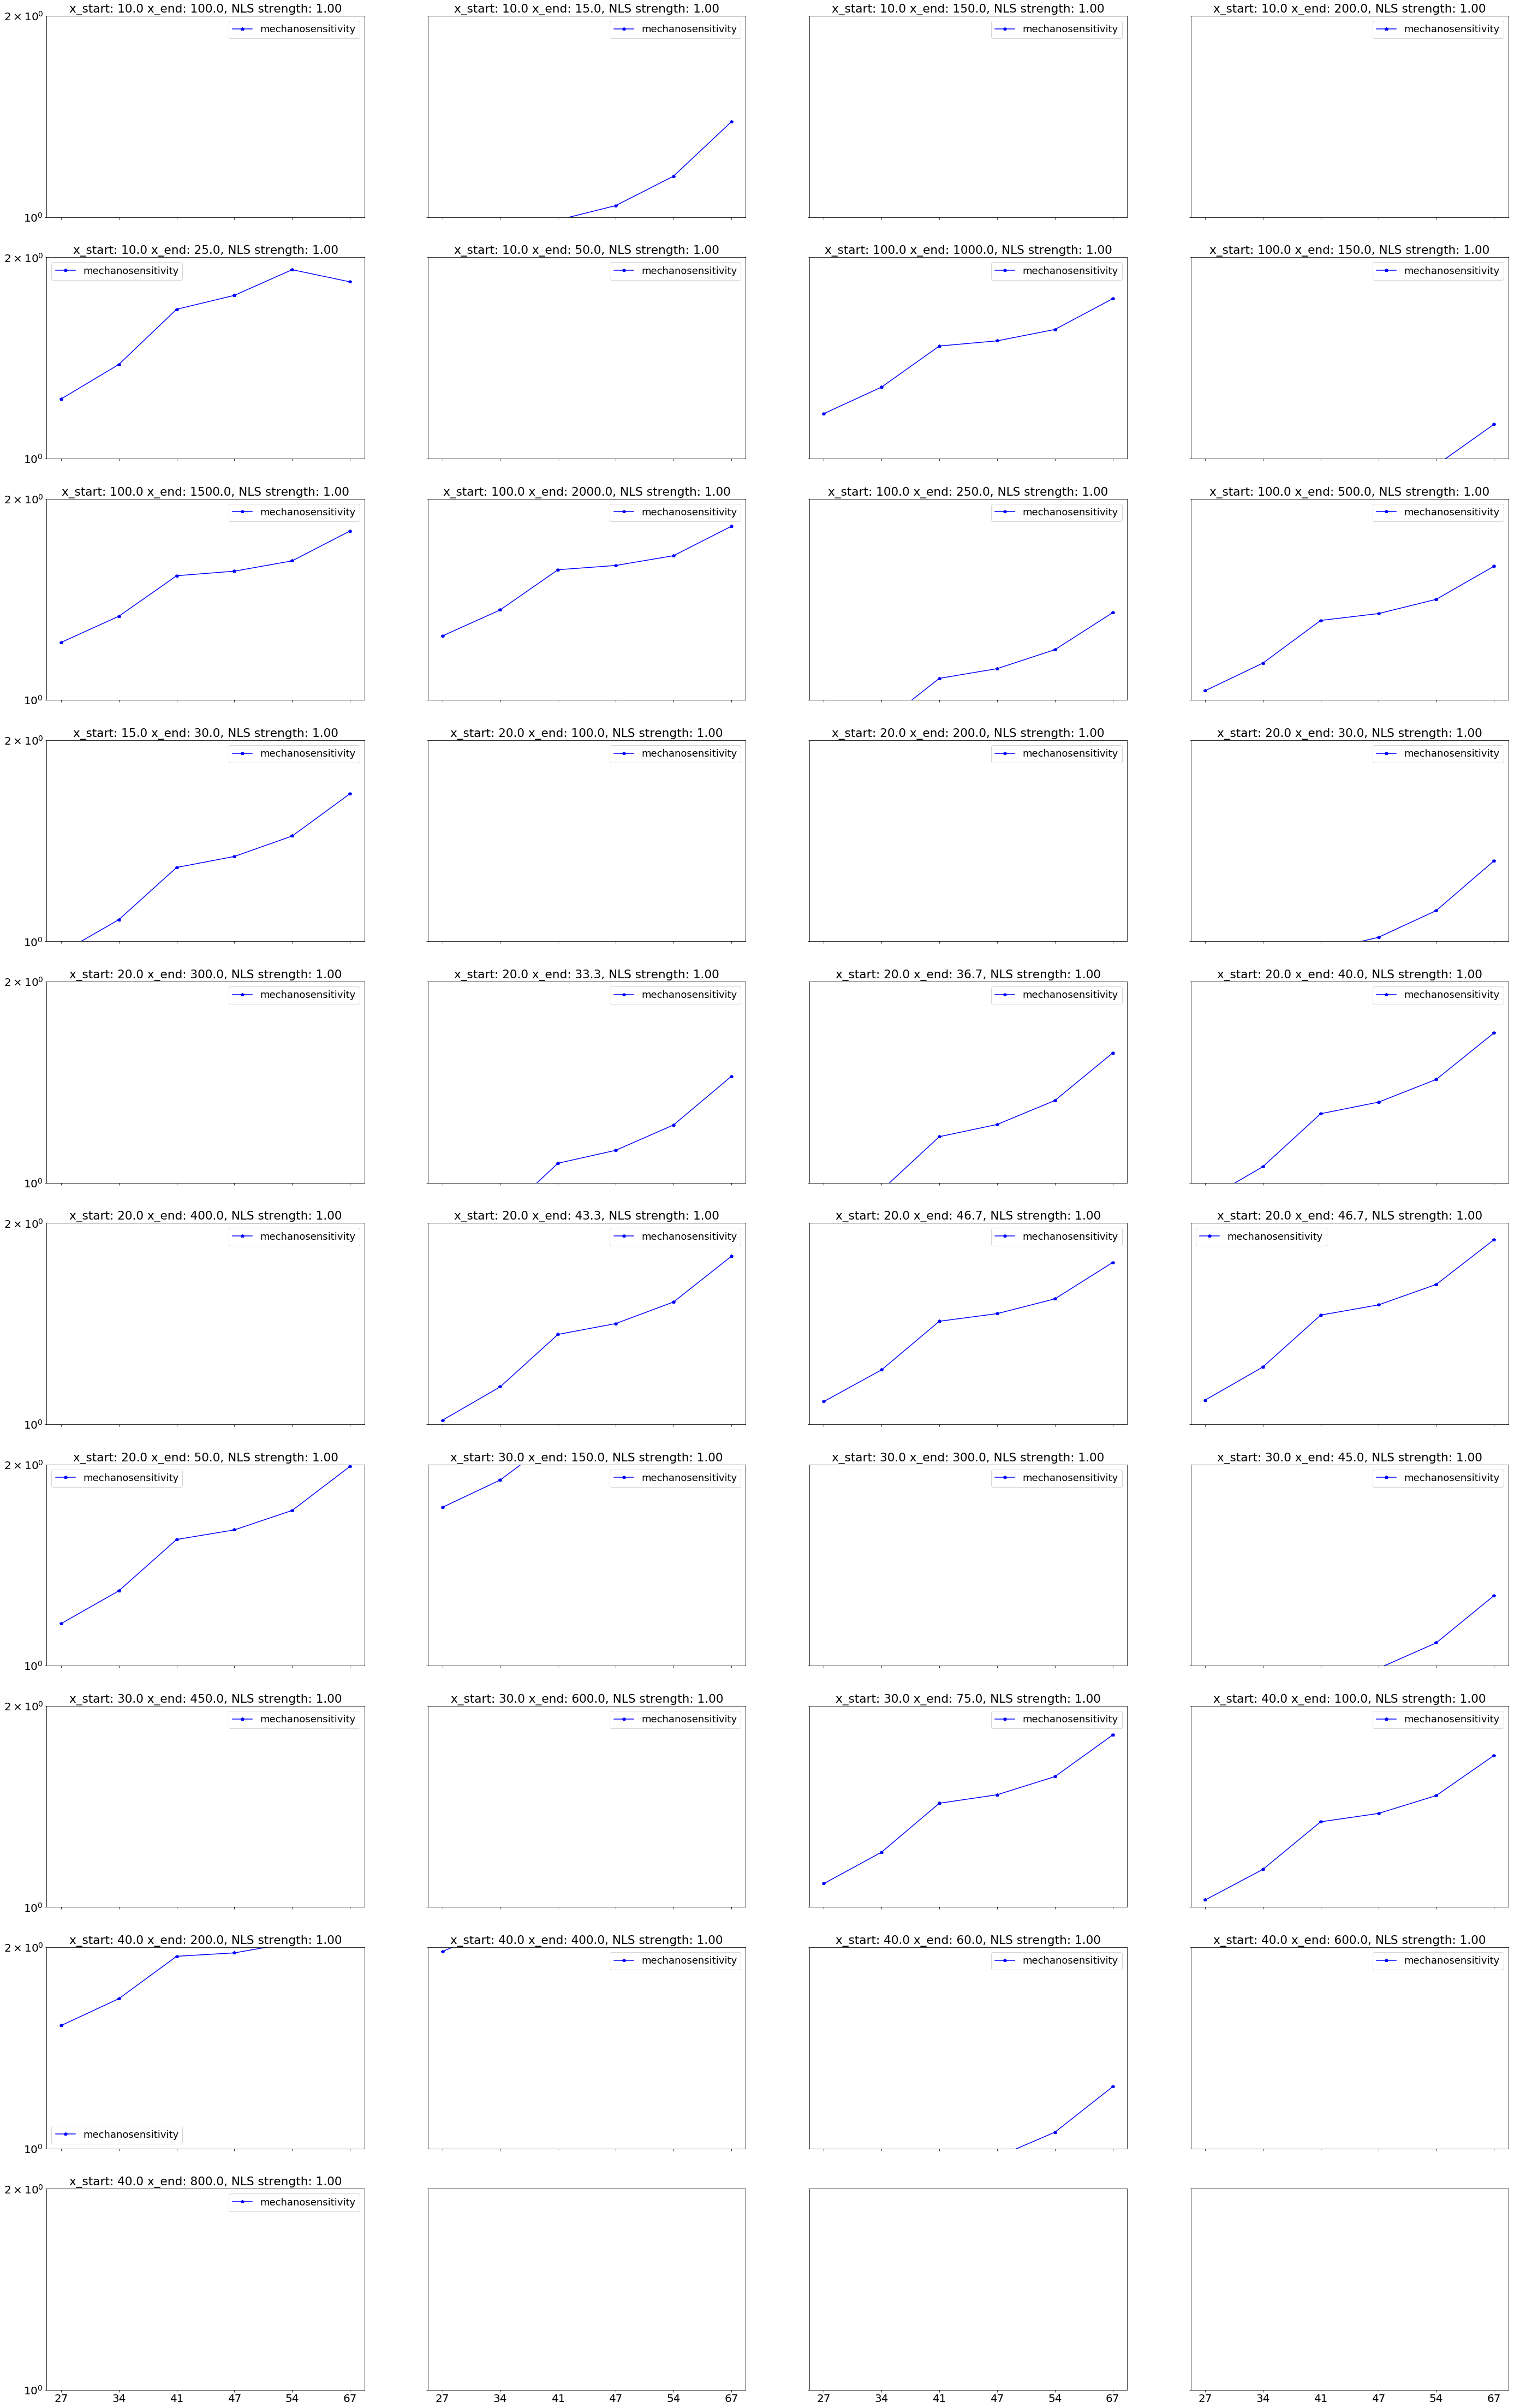

In [46]:

import math

def grid_per_nls(nls, ran_factor=None):
    files = glob.glob(f"{grid_dir}/*.pkl")
    if ran_factor is not None:
        for file in files:
            xs, xe, rf = get_xvals_from_filename(file)
            if int(rf) != ran_factor:
                files.remove(file)
    files.sort()
    n = len(files)

    ncols = 4
    nrows = int(math.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12*ncols, 8*nrows), squeeze=False, sharex=True, sharey=True)
    

    for i,j in np.ndindex((nrows, ncols)):
        file_i = ncols*i + j
        if file_i == n:
            break
        make_graph_from_file(files[file_i], nls, axes[i,j])
    
        
for i in range(7):
    grid_per_nls(i, 5)
    plt.show()

5.0 5.5 2
5.0 5.8 2
5.0 6.0 2
5.0 6.5 2
5.0 10.0 2
7.0 7.7 2
7.0 8.0 2
7.0 8.4 2
7.0 9.1 2
7.0 14.0 2
10.0 11.0 2
10.0 11.5 2
10.0 12.0 2
10.0 13.0 2
10.0 14.0 2
10.0 15.0 2
10.0 15.0 5
10.0 16.8 2
10.0 20.0 2
10.0 25.0 5
10.0 50.0 5
10.0 100.0 5
10.0 150.0 5
10.0 200.0 5
15.0 20.0 2


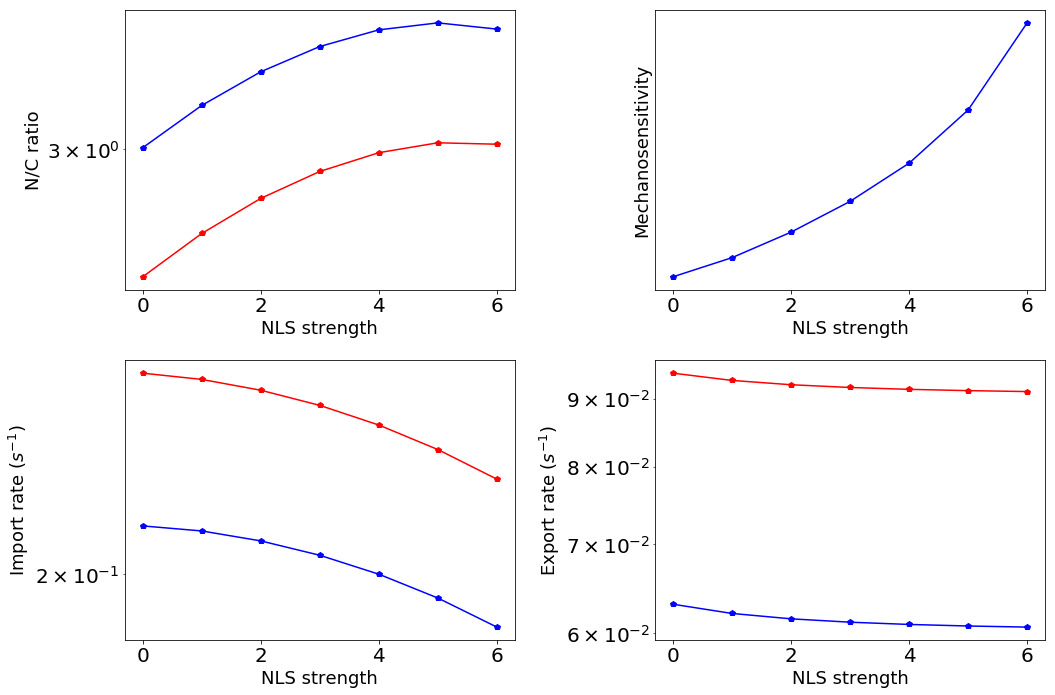

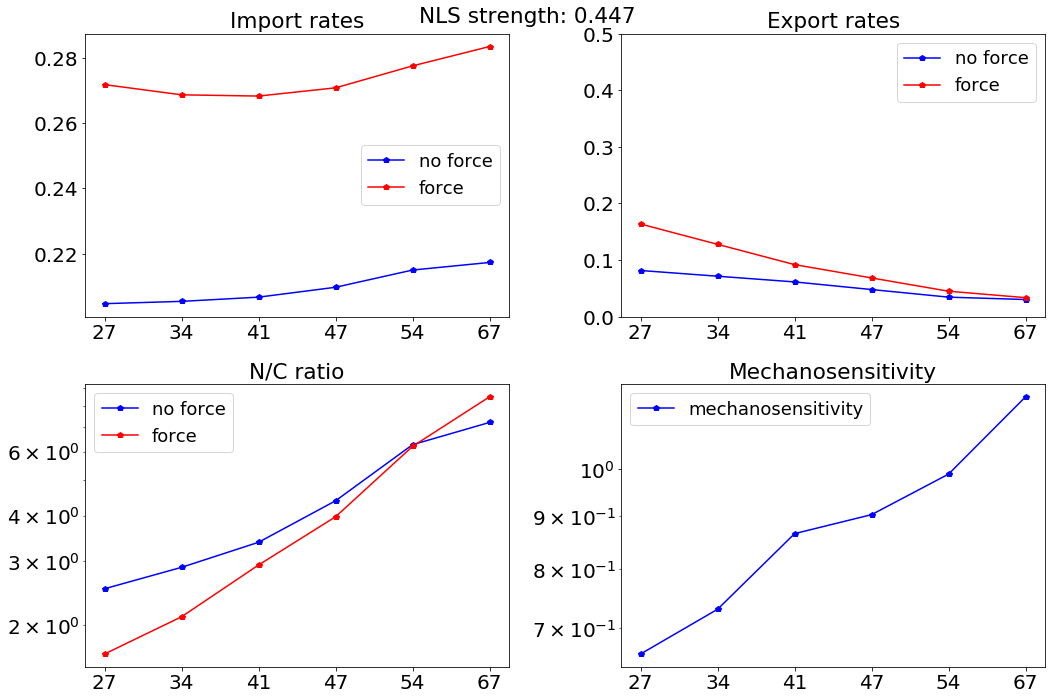

15.0 25.0 2


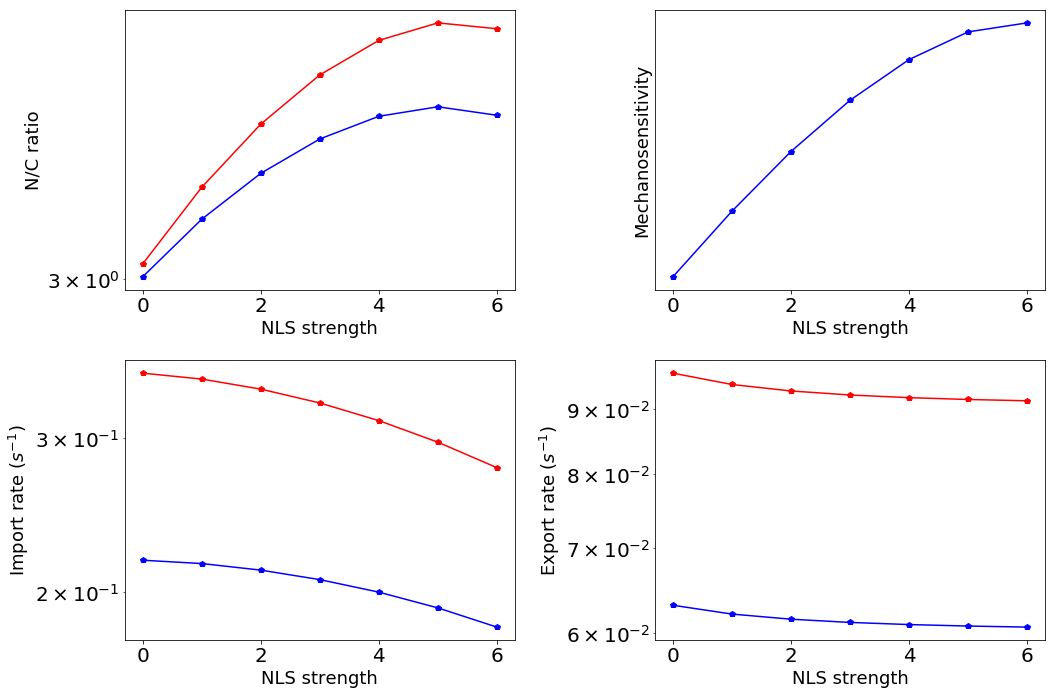

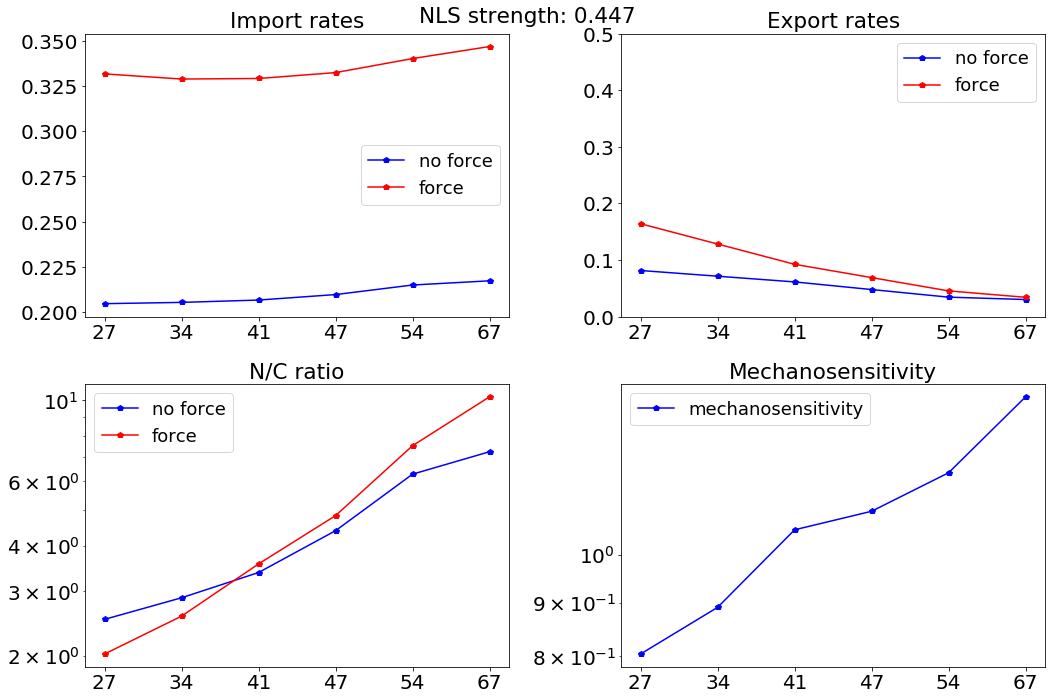

15.0 25.0 3


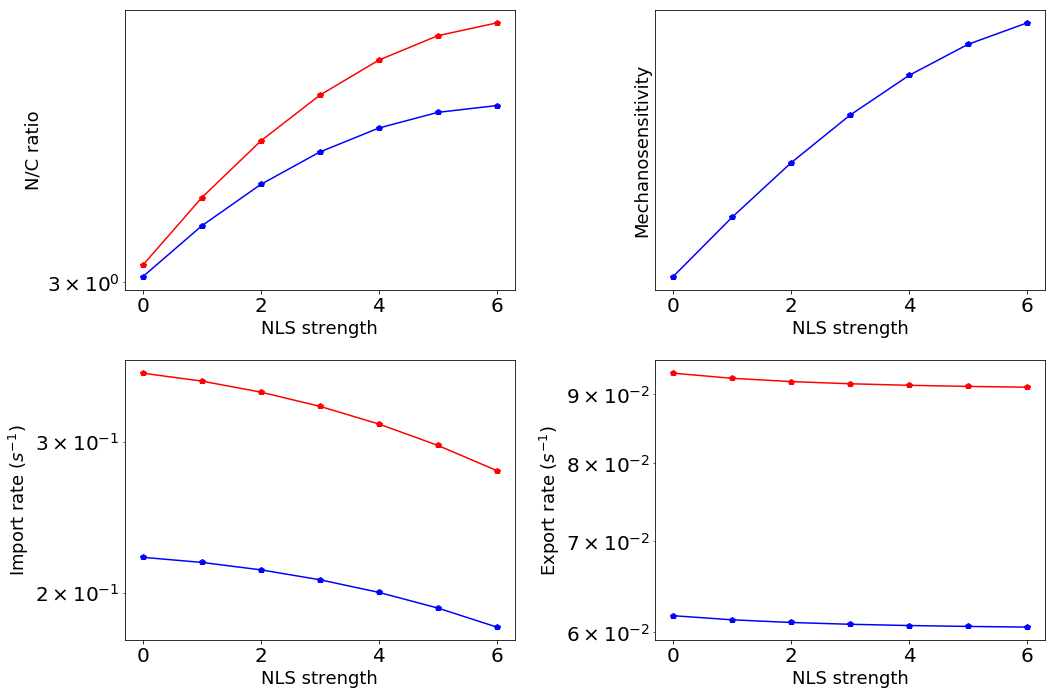

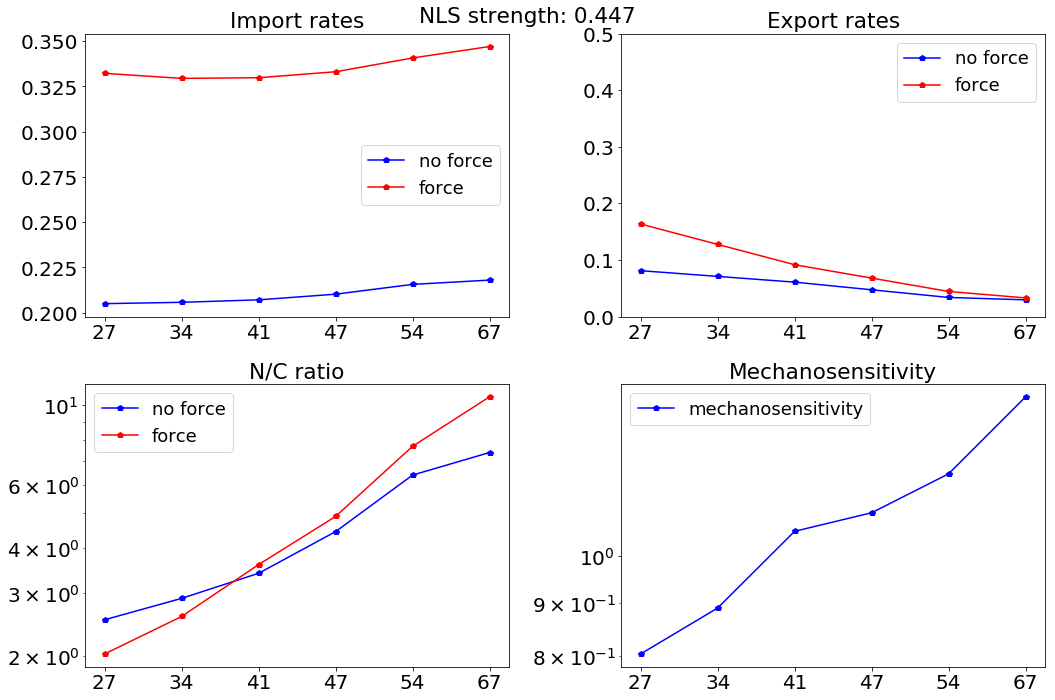

15.0 27.5 2


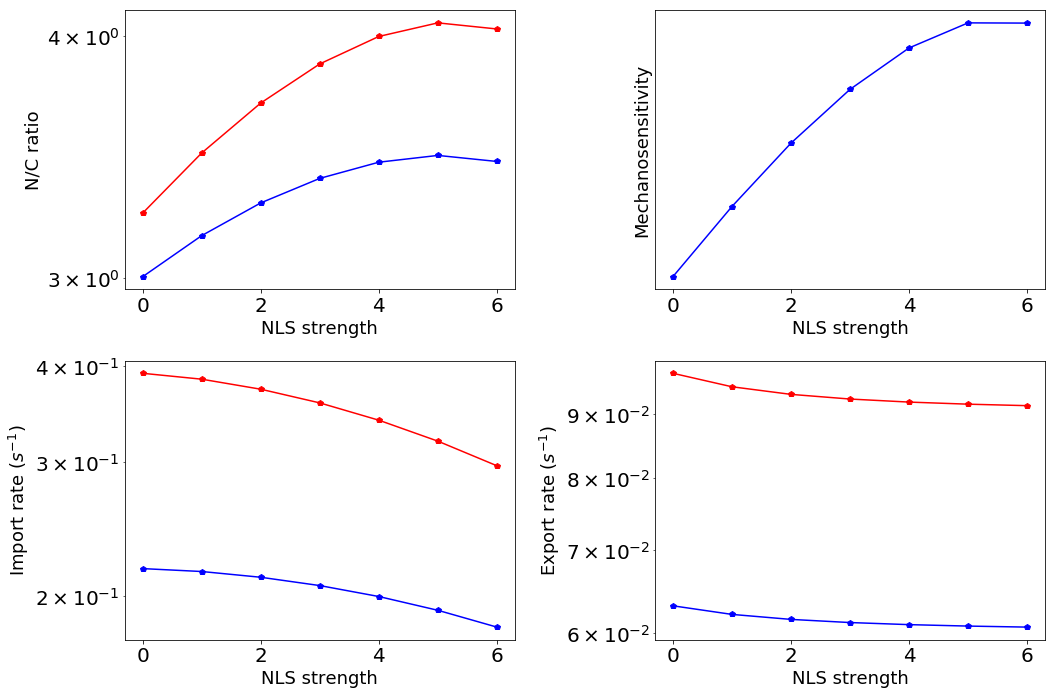

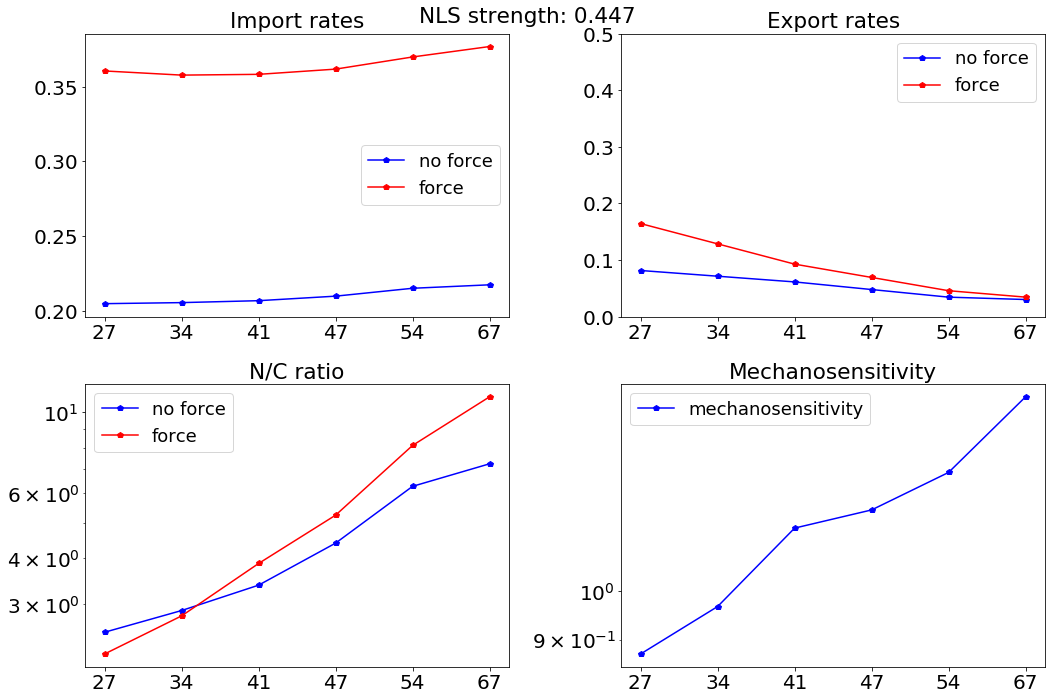

15.0 27.5 3


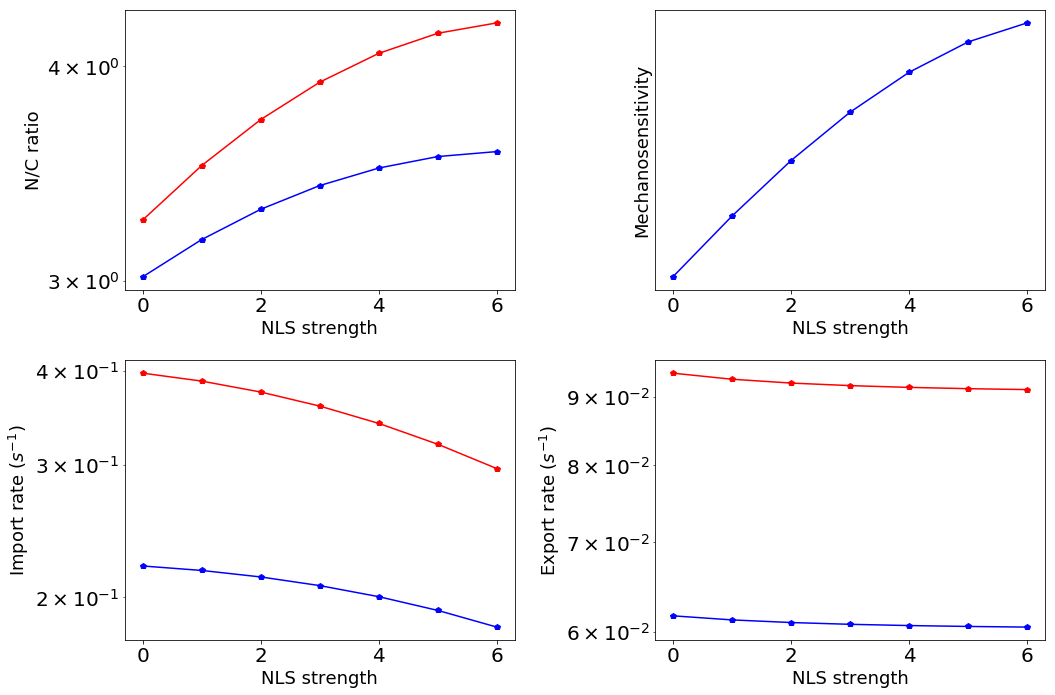

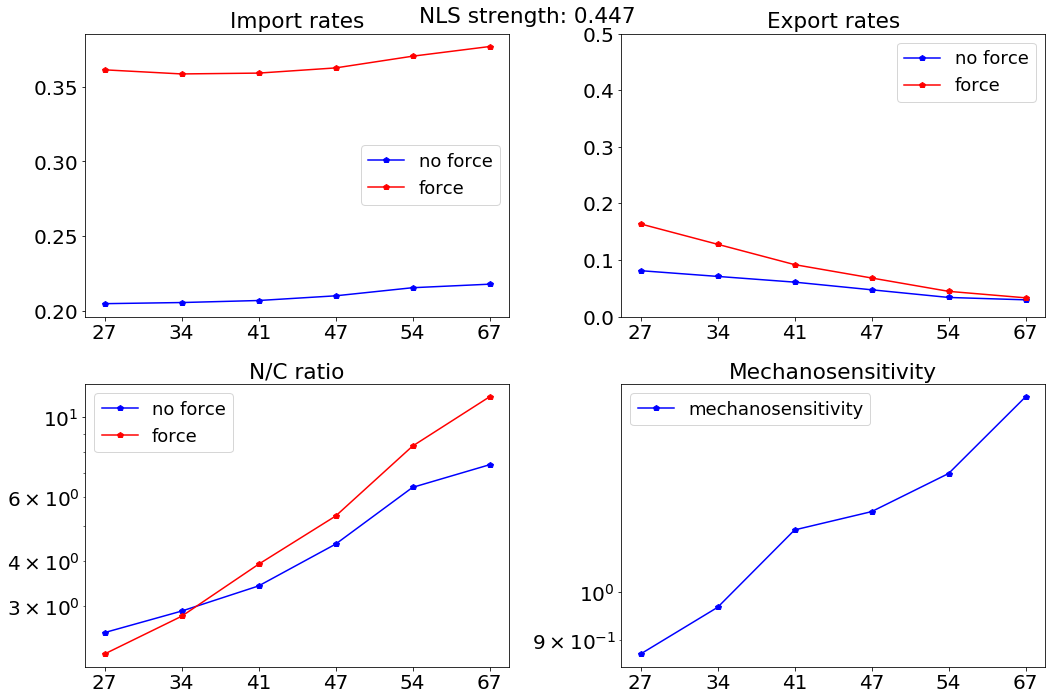

15.0 30.0 2


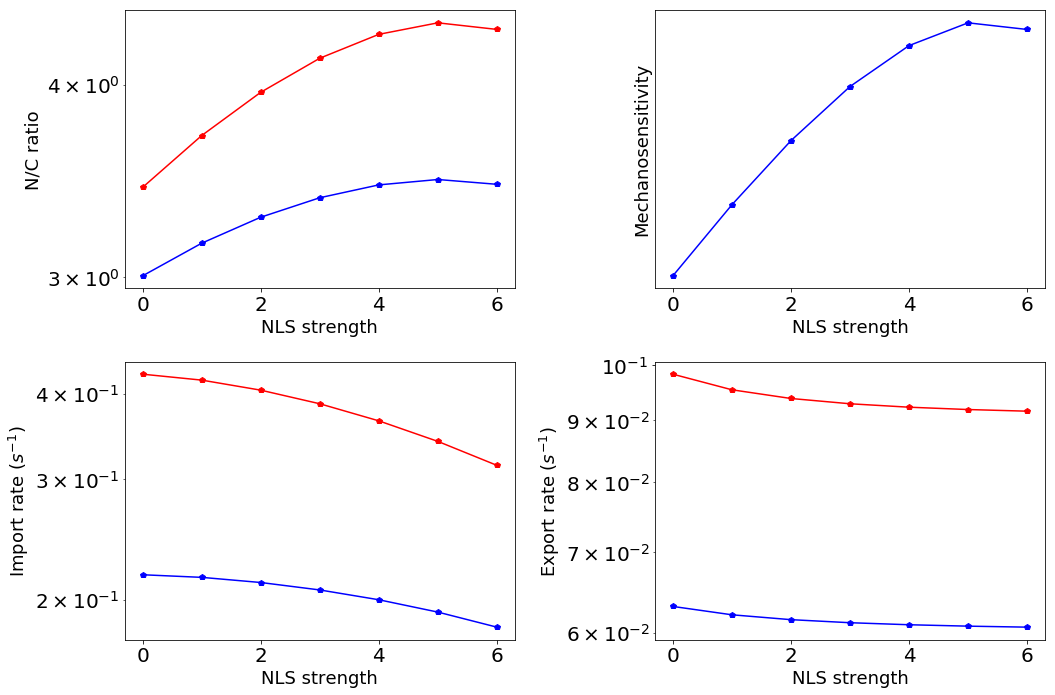

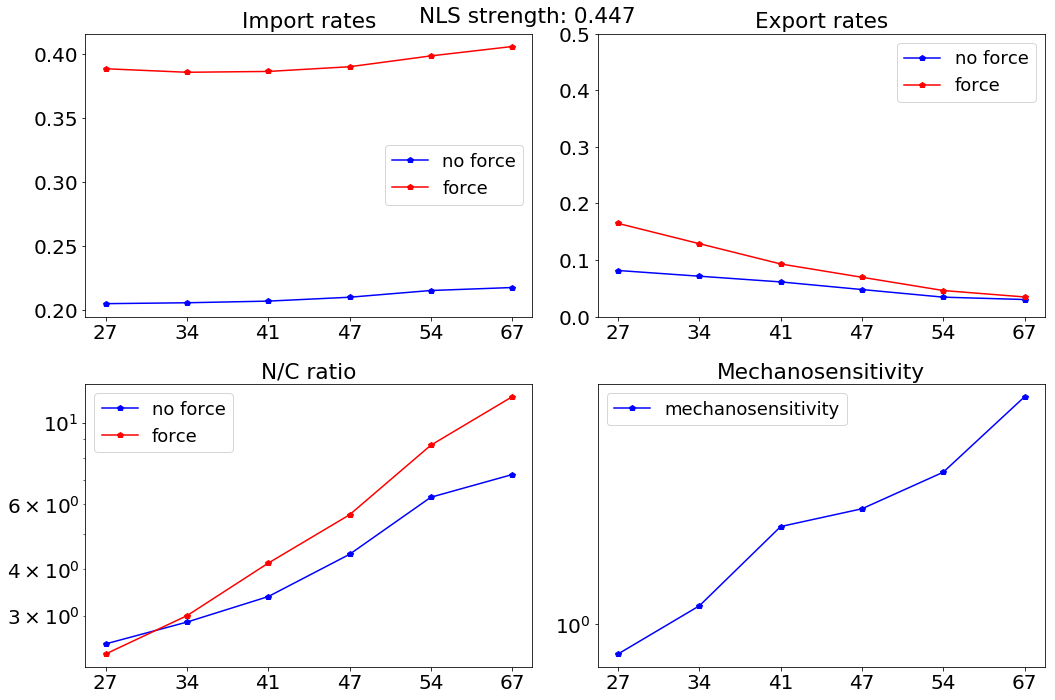

15.0 30.0 3


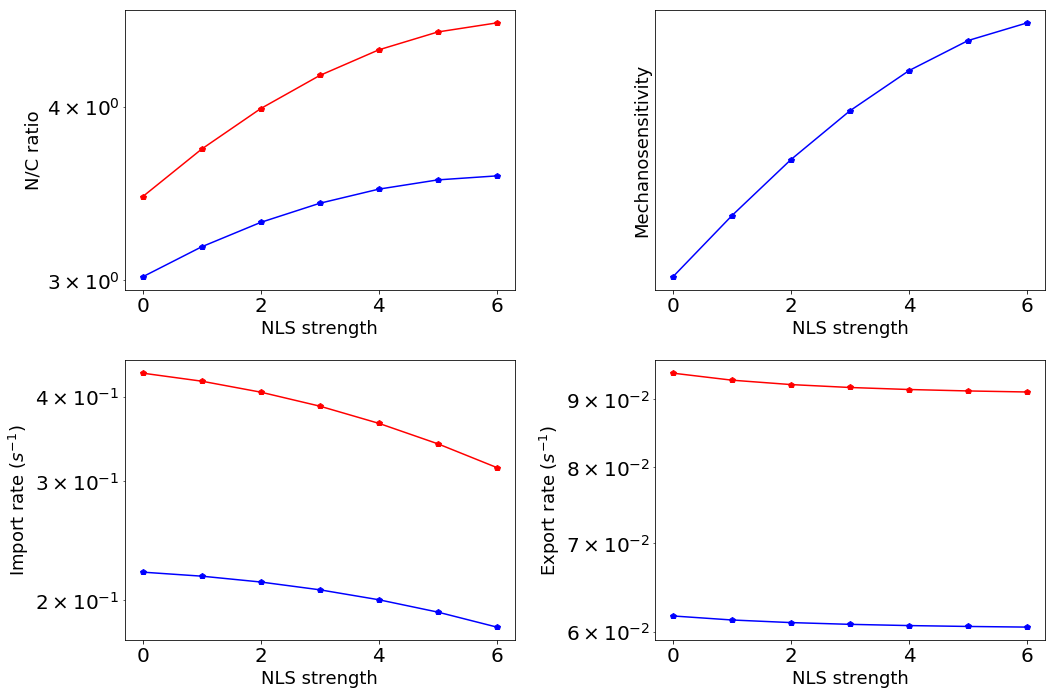

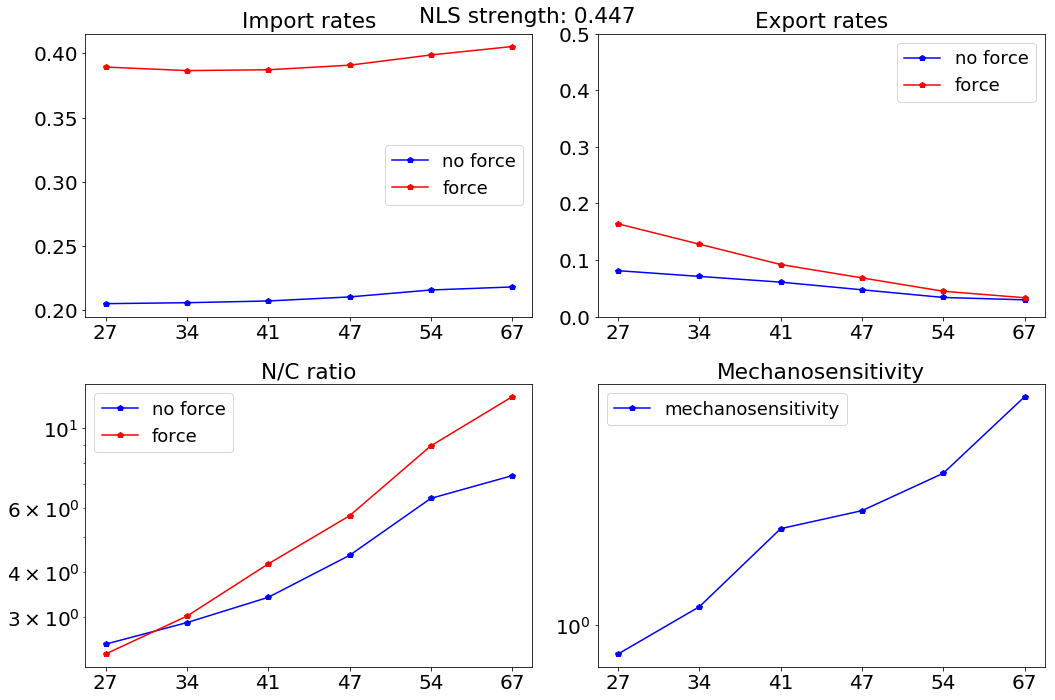

15.0 32.5 2


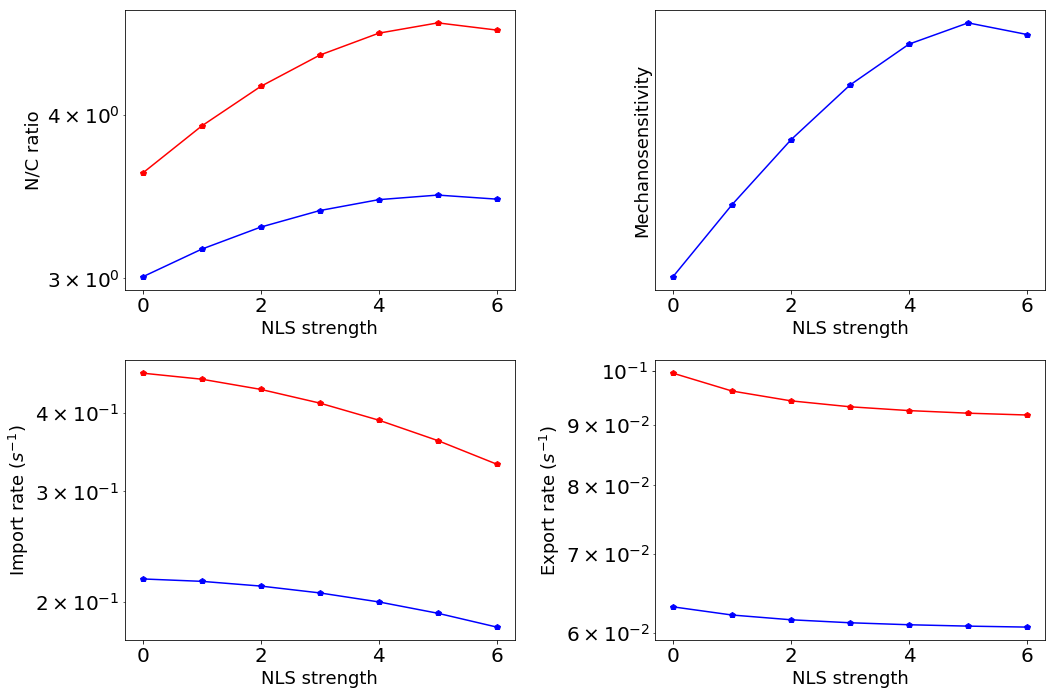

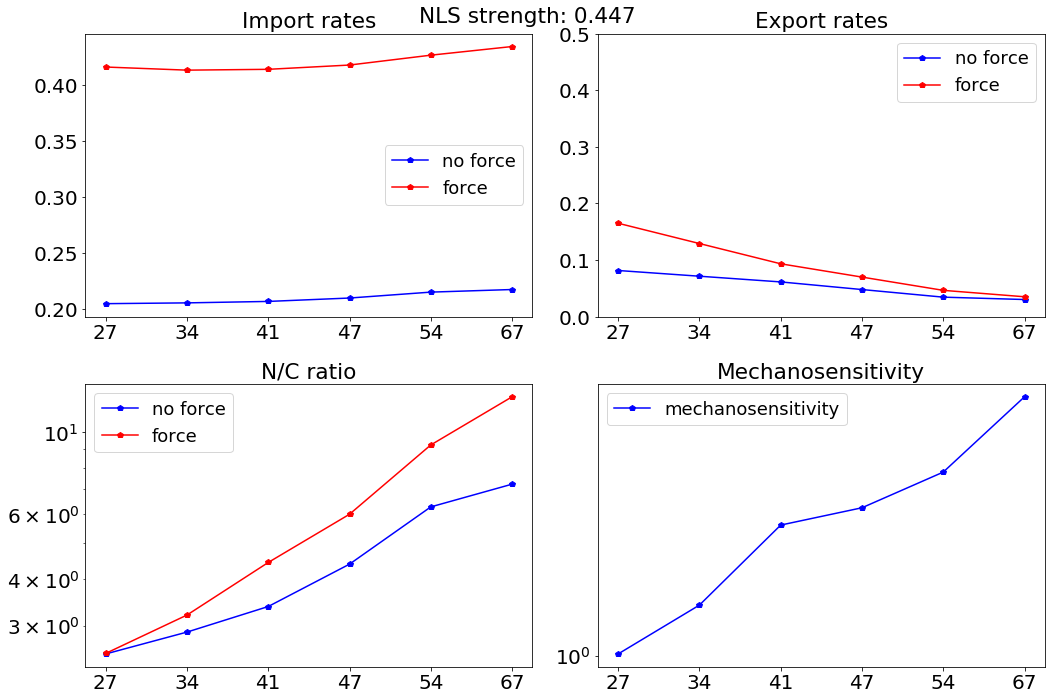

15.0 32.5 3


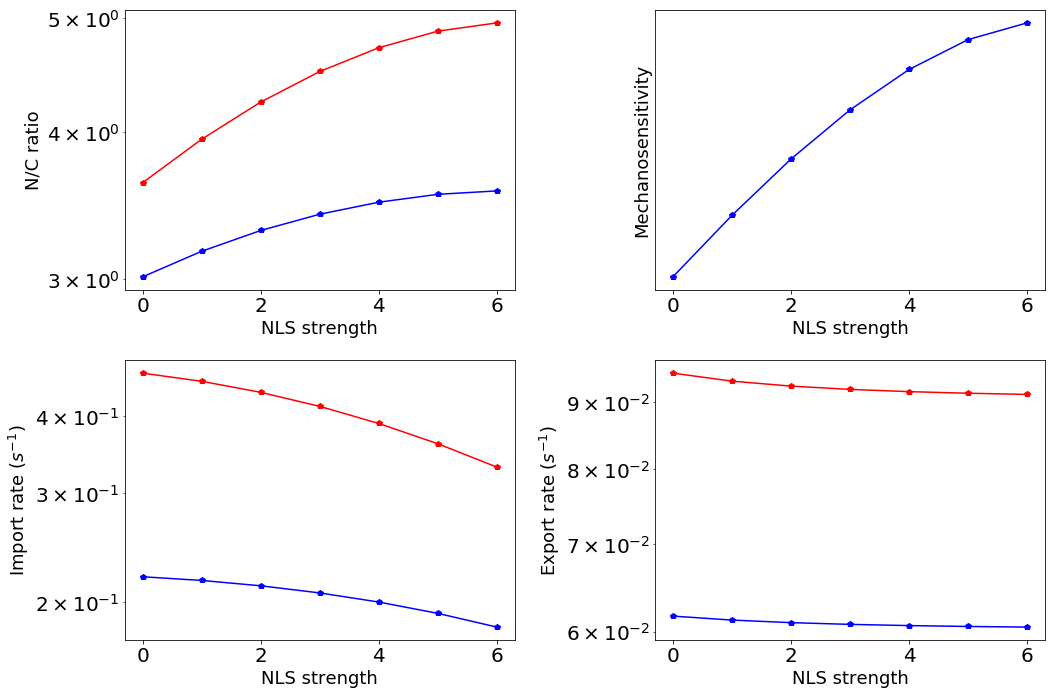

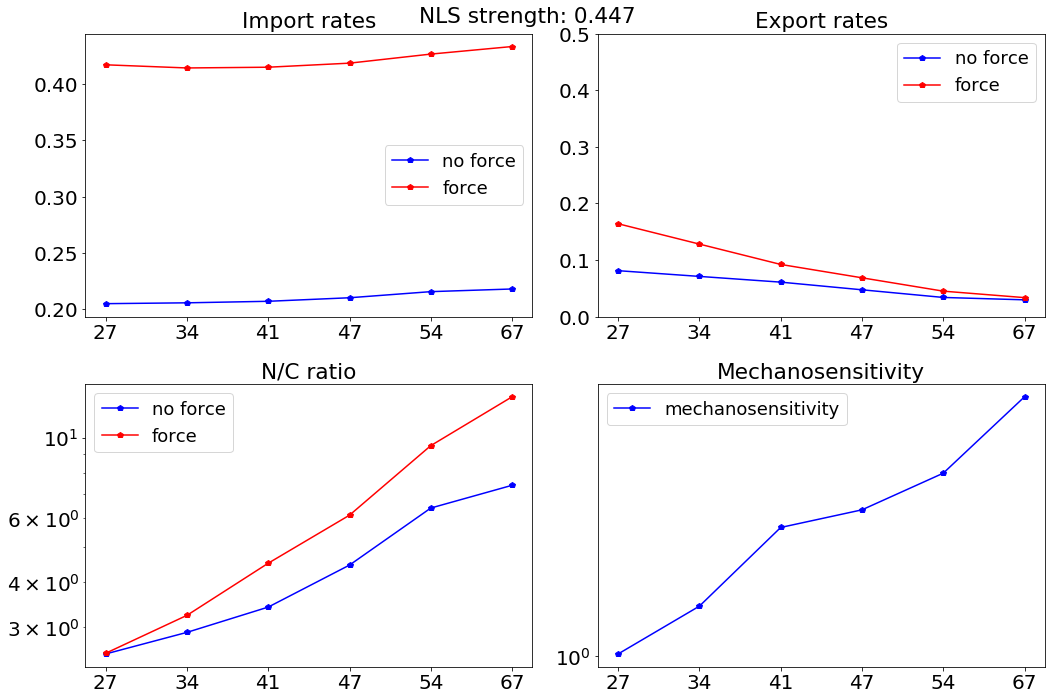

15.0 35.0 3


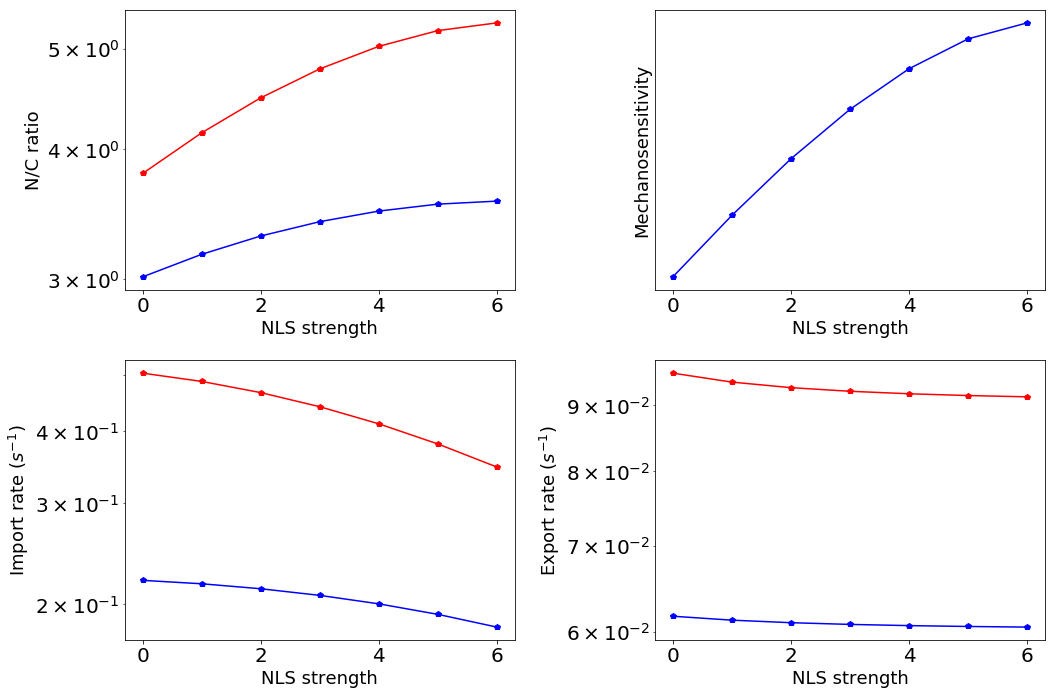

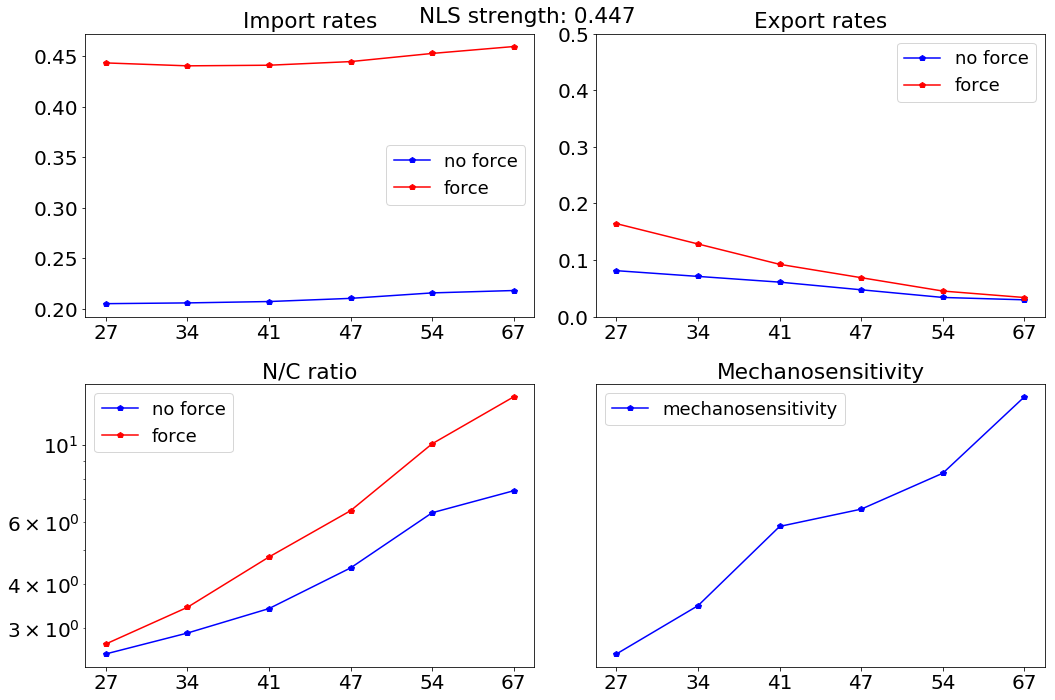

15.0 67.5 9


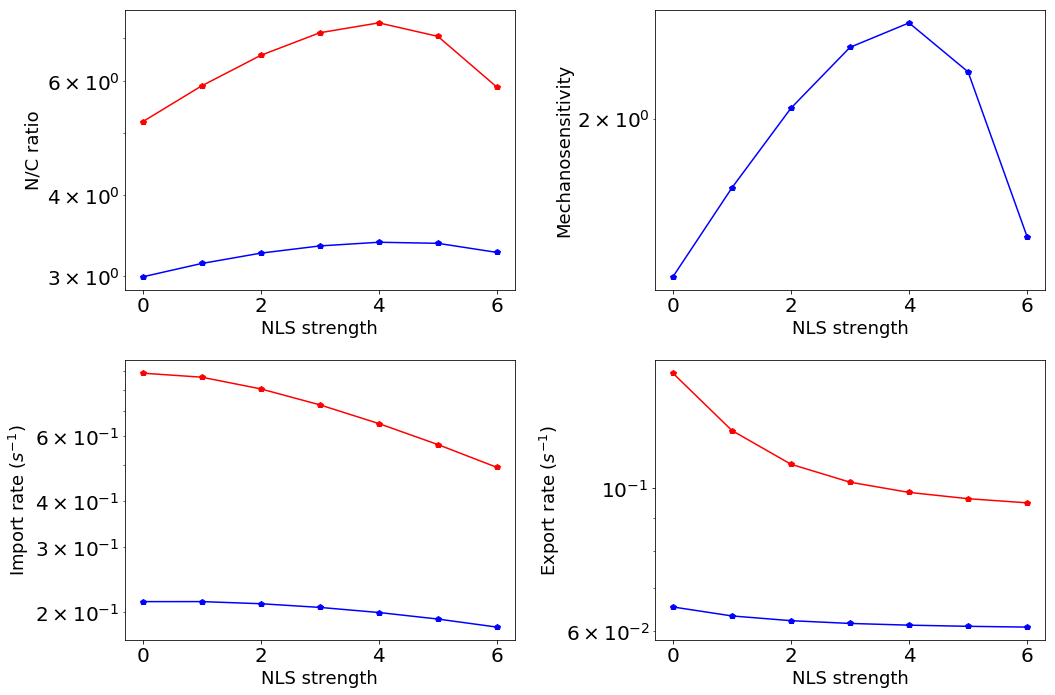

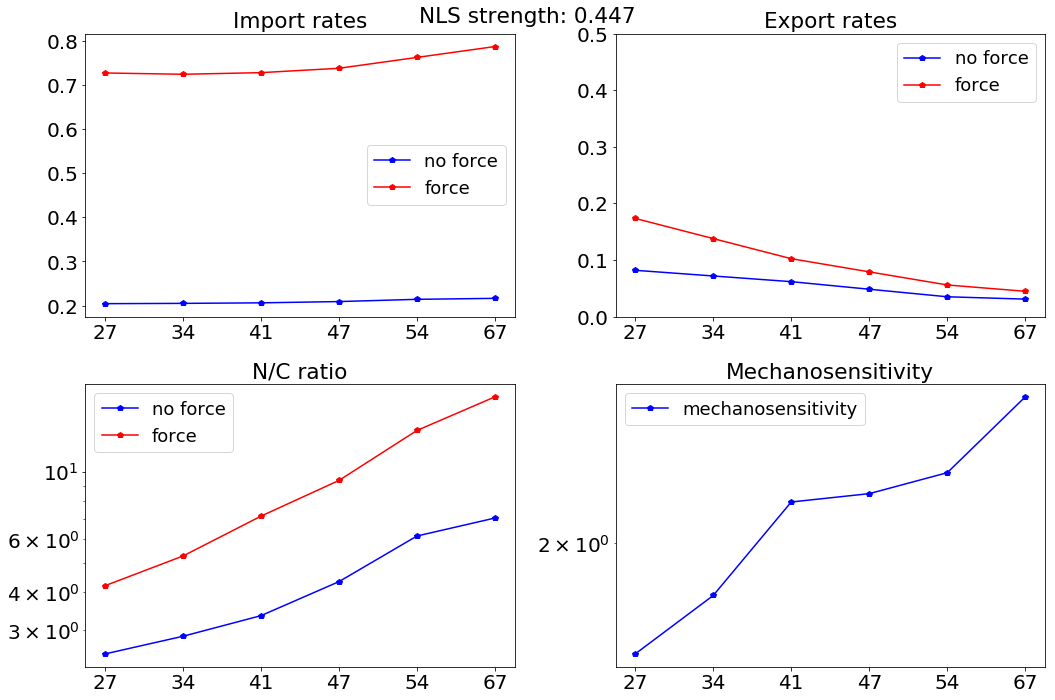

20.0 26.7 2
20.0 30.0 5
20.0 33.3 2
20.0 33.3 3
20.0 33.3 5
20.0 36.7 2
20.0 36.7 3
20.0 36.7 5
20.0 40.0 2
20.0 40.0 3
20.0 40.0 5
20.0 43.3 2
20.0 43.3 3
20.0 43.3 5
20.0 46.7 3
20.0 46.7 5
20.0 50.0 5
20.0 100.0 5
20.0 200.0 5
20.0 300.0 5
20.0 400.0 5
25.0 33.3 2
25.0 41.7 2
25.0 41.7 3
25.0 45.8 2
25.0 45.8 3
25.0 50.0 2
25.0 50.0 3
25.0 54.2 2
25.0 54.2 3
25.0 58.3 3
30.0 45.0 5
30.0 75.0 5
30.0 150.0 5
30.0 300.0 5
30.0 450.0 5
30.0 600.0 5
40.0 60.0 5
40.0 100.0 5
40.0 200.0 5
40.0 400.0 5
40.0 600.0 5
40.0 800.0 5
100.0 150.0 5
100.0 250.0 5
100.0 500.0 5
100.0 1000.0 5
100.0 1500.0 5
100.0 2000.0 5


In [75]:

grid_dir = 'slurm/grid'
results = get_all_results()
for xs, xe, rf in results:
    print(xs, xe, rf)
    if xs == 15: 
        make_full_graphs(xs, xe, 3, rf)
        plt.show()


In [71]:
import pdb; pdb.pm()

> <ipython-input-53-b96576ab9557>(13)get_xvals_from_filename()
-> res_str = pattern.match(filename).groups()


(Pdb)  filename


'slurm/grid/15.0_67.5_15.pkl'


(Pdb)  q


0.0382065915665814 0.04459986 0.05671193
0.012672422899300128 0.01568573 0.01877862
0.008890659075046003 0.01400538 0.01115704
0.00884154644829002 0.01429939 0.0109108


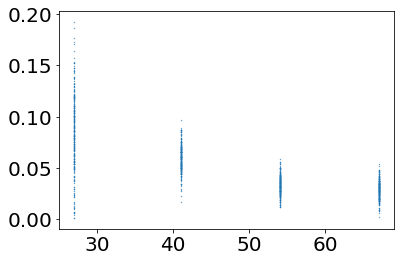

In [127]:
from sklearn.linear_model import LinearRegression as LR
n = 300
MWs = np.array([27.0, 41.0, 54.0, 67.0])

imp_mus = [0.07624291,
0.0560286,
0.03452787,
0.03022162]

imp_sigs = [0.04459986,
0.01568573,
0.01400538,
0.01429939]

f_imp_mus = [0.1632329,
0.08997895,
0.03433635,
0.031995]

f_imp_sigs = [0.07503824,
0.0423378,
0.0114681,
0.01033417]

exp_mus = [0.08488068,
0.06441849,
0.03150536,
0.02730817]

exp_sigs = [0.05671193,
0.01877862,
0.01115704,
0.0109108]

f_exp_mus = [0.1621896,
0.09102761,
0.03222303,
0.03098126]

f_exp_sigs = [0.1188227,
0.04425379,
0.00988231,
0.00955281]

data = np.zeros(4*n)
data_f = np.zeros(4*n)
x=[]
for i in range(4):
    imp = np.random.normal(imp_mus[i], imp_sigs[i], n)
    exp = np.random.normal(exp_mus[i], exp_sigs[i], n)
    passive = (imp+exp)/2
    data[i*n:(i+1)*n] = np.abs(passive)
    print(np.std(passive), imp_sigs[i], exp_sigs[i])
    
    f_imp = np.random.normal(f_imp_mus[i], f_imp_sigs[i], n)
    f_exp = np.random.normal(f_exp_mus[i], f_exp_sigs[i], n)
    f_passive = (f_imp+f_exp)/2
    data_f[i*n:(i+1)*n] = np.abs(f_passive)
    
    x += [MWs[i]]*n
    
X = np.array(x).reshape(-1,1)
passive.shape
plt.scatter(X, (data), s=0.1)
#plt.yscale('log')

In [128]:
regr = LR()
regr.fit(X, np.log(data))
pred = regr.predict(np.array([27,41,54,67]).reshape(-1,1))
pred = np.exp(pred)

regr = LR()
regr.fit(X, np.log(data_f))
pred_f = regr.predict(np.array([27,41,54,67]).reshape(-1,1))
pred_f = np.exp(pred_f)

(0.01, 0.4)

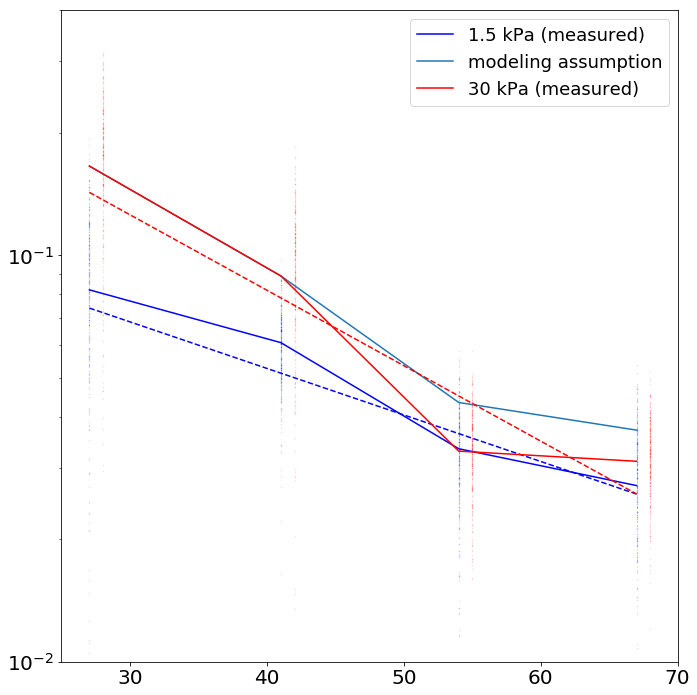

In [151]:
plt.figure(figsize=(10,10))
plt.plot(MWs, means, 'b-', label='1.5 kPa (measured)')
plt.plot(MWs, pred, 'b--')

plt.plot(MWs, np.append(means_f[:2], means[2:]+np.array([0.01,0.01])), label='modeling assumption')

plt.plot(MWs, means_f, 'r-', label='30 kPa (measured)')
plt.plot(MWs, pred_f, 'r--')



plt.scatter(X, (data), c='b', s=0.1, alpha=0.2)
plt.scatter(X+1, (data_f), c='r', s=0.1, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.yscale('log')
plt.ylim((0.01, 0.4))


In [142]:
(pred_f - pred)[2]

0.008652113009787445